In [1]:
# 나눔고딕 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# # 패키지 설치
!pip install -U kiwipiepy tomotopy flashtext gensim pandas-read-xml kss -q

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import matplotlib as mpl
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumBarunGothic')
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
import matplotlib.colors as clr

from collections import Counter
import regex
import re

from kiwipiepy import Kiwi, Option
kiwi = Kiwi()
kiwi.prepare()

from flashtext import KeywordProcessor
kp = KeywordProcessor()

import tomotopy as tp
print(tp.isa)
import sys
from sklearn import preprocessing

import pandas_read_xml as pdx
from pandas_read_xml import flatten, fully_flatten, auto_separate_tables

from kss import split_sentences
import itertools
from collections import defaultdict
import pickle

import nltk
from nltk import collocations
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


avx2


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Text(0.5, 0, '시간(분)')

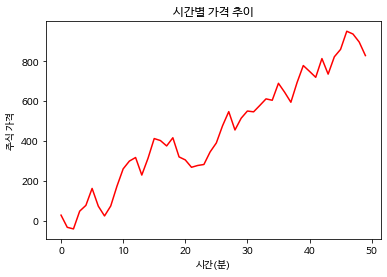

In [3]:
# plot 한글 깨짐 확인용
data = np.random.randint(-100, 100, 50).cumsum()
plt.plot(range(50), data, 'r')
# mpl.rcParams['axes.unicode_minus'] = False
plt.title('시간별 가격 추이')
plt.ylabel('주식 가격')
plt.xlabel('시간(분)')

### 전처리


In [4]:
# 위키문헌 xml 파일 다운
# https://drive.google.com/file/d/15yJtJ11rFwxbLMS3Sqyl-YboxFhgoxT2/view?usp=sharing
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=15yJtJ11rFwxbLMS3Sqyl-YboxFhgoxT2" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=15yJtJ11rFwxbLMS3Sqyl-YboxFhgoxT2" -o kowikisource2_sep.xml

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   3044      0 --:--:-- --:--:-- --:--:--  3044
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  206M    0  206M    0     0  66.3M      0 --:--:--  0:00:03 --:--:-- 88.2M


In [5]:
# xml 파일 읽기
df = pdx.read_xml('kowikisource2_sep.xml', ['wikisource'])
df

,doc
0,"[{'@id': '1', '@url': 'https://ko.wikisource.o..."


In [6]:
df = df.pipe(flatten)
df

,doc
0,"{'@id': '1', '@url': 'https://ko.wikisource.or..."
1,"{'@id': '2', '@url': 'https://ko.wikisource.or..."
2,"{'@id': '3', '@url': 'https://ko.wikisource.or..."
3,"{'@id': '7', '@url': 'https://ko.wikisource.or..."
4,"{'@id': '14', '@url': 'https://ko.wikisource.o..."
...,...
24099,"{'@id': '52620', '@url': 'https://ko.wikisourc..."
24100,"{'@id': '52621', '@url': 'https://ko.wikisourc..."
24101,"{'@id': '52622', '@url': 'https://ko.wikisourc..."
24102,"{'@id': '52623', '@url': 'https://ko.wikisourc..."


In [7]:
df = df.pipe(flatten)
df

,doc|@id,doc|@url,doc|@title,doc
0,1,https://ko.wikisource.org/wiki?curid=1,애국가 (대한민국),애국가 (대한민국)\n\n한자 혼용
1,2,https://ko.wikisource.org/wiki?curid=2,대한민국 헌법 (한자혼용),대한민국 헌법 (한자혼용)\n\n<sep> 한글 전용 표기
2,3,https://ko.wikisource.org/wiki?curid=3,조선민주주의인민공화국 사회주의헌법,조선민주주의인민공화국 사회주의헌법\n\n서문.\n조선민주주의인민공화국은 위대한 김일...
3,7,https://ko.wikisource.org/wiki?curid=7,대한민국 한글 맞춤법(제88-1호),대한민국 한글 맞춤법(제88-1호)\n\n<sep>==제1장 총 칙==<sep>제 ...
4,14,https://ko.wikisource.org/wiki?curid=14,"민법 (대한민국, 제8720호)","민법 (대한민국, 제8720호)\n\n<sep>== 제1편 총칙 ==<sep>===..."
...,...,...,...,...
24099,52620,https://ko.wikisource.org/wiki?curid=52620,가덕도신공항 거설을 위한 특별법 (제17938호),가덕도신공항 거설을 위한 특별법 (제17938호)
24100,52621,https://ko.wikisource.org/wiki?curid=52621,가덕도신공항 건설을 위한 특별법,가덕도신공항 건설을 위한 특별법\n\n<sep>== 연혁 ==
24101,52622,https://ko.wikisource.org/wiki?curid=52622,국가경찰위원회 규정 (제31380호),국가경찰위원회 규정 (제31380호)\n\n<onlyinclude>
24102,52623,https://ko.wikisource.org/wiki?curid=52623,경찰위원회규정,경찰위원회규정


In [8]:
# 문학(산문) 작품만 가져오기
# https://drive.google.com/file/d/1c1qbbX1vwZfH3dAV7Ffj8WhVH4d5bifD/view?usp=sharing
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1c1qbbX1vwZfH3dAV7Ffj8WhVH4d5bifD' -O 210426_위키문헌_작품목록_통합.csv

--2021-05-30 15:04:00--  https://drive.google.com/uc?export=download&id=1c1qbbX1vwZfH3dAV7Ffj8WhVH4d5bifD
Resolving drive.google.com (drive.google.com)... 172.217.13.78, 2607:f8b0:4004:808::200e
Connecting to drive.google.com (drive.google.com)|172.217.13.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-5s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8o3hqeklotntlhi45tpb80j6fci8glaj/1622387025000/12350511020204598408/*/1c1qbbX1vwZfH3dAV7Ffj8WhVH4d5bifD?e=download [following]
--2021-05-30 15:04:00--  https://doc-10-5s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8o3hqeklotntlhi45tpb80j6fci8glaj/1622387025000/12350511020204598408/*/1c1qbbX1vwZfH3dAV7Ffj8WhVH4d5bifD?e=download
Resolving doc-10-5s-docs.googleusercontent.com (doc-10-5s-docs.googleusercontent.com)... 142.251.33.193, 2607:f8b0:4004:837::2001
Connecting to doc-10-5s-docs.googleusercontent.com (doc-10-5s-docs.go

In [9]:
article =pd.read_csv('210426_위키문헌_작품목록_통합.csv')
article

,종류,작품명,위키제목,저자,출처,연도,시대,시대_N
0,노래,애국가,애국가 (대한민국),윤치호,NaN,1897,1890,E1
1,수필,시일야방성대곡,시일야방성대곡,장지연,황성신문,1905,1900,E1
2,소설,혈의 누,혈의 누/현대어 해석,이인직,만세보,1906,1900,E1
3,신소설,귀의 성,귀의 성,이인직,NaN,1907,1900,E1
4,시,가을 뜻,가을 뜻,최남선,NaN,1908,1900,E1
...,...,...,...,...,...,...,...,...
2432,수필,허식의 변,허식의 변,김상용,NaN,미상,미상,NaN
2433,소설,홍윤성과 절부,홍윤성과 절부,윤백남,NaN,미상,미상,NaN
2434,시,화제,화제,이육사,NaN,미상,미상,NaN
2435,시,황해의 첫봄,황해의 첫봄,김억,NaN,미상,미상,NaN


In [10]:
# 시대 '미상' 제거
article = article[article['시대']!='미상']

In [11]:
# 소설, 수필, 신소설, 동화, 평론, 칼럼만 포함
valid_title = article.loc[article['종류'].isin(['소설','수필','동화','신소설','칼럼','평론','희곡','격문','금석문','추도사','퇴임사','담화문']),'위키제목'].to_list()
len(valid_title)

1152

In [12]:
# 시대별 작품수
article.loc[article['종류'].isin(['소설','수필','동화','신소설','칼럼','평론','희곡','격문','금석문','추도사','퇴임사','담화문']),'시대_N'].value_counts().sort_index()

E1     73
E2    819
E3    259
Name: 시대_N, dtype: int64

In [13]:
# valid_title Filter
df = df.loc[df['doc|@title'].isin(valid_title)]
df

,doc|@id,doc|@url,doc|@title,doc
24,1350,https://ko.wikisource.org/wiki?curid=1350,백범일지,백범일지\n\n저자의 말.\n하여서 딱 거절하였다.<sep>그런즉 일인이 다시 말하...
35,1370,https://ko.wikisource.org/wiki?curid=1370,날개,날개\n\n<sep>‘박제가 되어 버린 천재’를 아시오? 나는 유쾌하오. 이런 때 ...
129,1810,https://ko.wikisource.org/wiki?curid=1810,산골 나그네,산골 나그네\n\n<sep>밤이 깊어도 술군은 역시들지 않는다. 메주 뜨는 냄새와 ...
132,1847,https://ko.wikisource.org/wiki?curid=1847,달을 쏘다,달을 쏘다\n\n<sep>번거롭던 사위(四圍)가 잠잠해지고 시계 소리가 또렷하나 보...
135,1852,https://ko.wikisource.org/wiki?curid=1852,지팽이 역사,지팽이 역사\n\n<sep>아침에 깨이기는 일찍 깨었다는 증거로 닭 우는 소리를 들...
...,...,...,...,...
22714,49942,https://ko.wikisource.org/wiki?curid=49942,대행애사,대행애사\n\n<sep>병인사월이십오일(丙寅四月二十五日)에 대행(大行)이 등하(登遐...
22718,49948,https://ko.wikisource.org/wiki?curid=49948,이충무공 묘산경매문제,이충무공 묘산경매문제\n\n일.\n환구오주(寰球五洲)에 어느 땅을 무를 것 없이 그...
23644,52075,https://ko.wikisource.org/wiki?curid=52075,가을과 산양,가을과 산양\n\n<sep>화단 위 해바라기 송이가 칙칙하게 시들었을 젠 벌써 가을...
23759,52207,https://ko.wikisource.org/wiki?curid=52207,가로의 요술사,"가로의 요술사\n\n<sep>“자 똑똑히 들어보세요, 똑똑히.”<sep>다 낡아서 ..."


In [14]:
# article, df Merge (inner)
df = df.merge(article,left_on='doc|@title',right_on='위키제목')
df

,doc|@id,doc|@url,doc|@title,doc,종류,작품명,위키제목,저자,출처,연도,시대,시대_N
0,1350,https://ko.wikisource.org/wiki?curid=1350,백범일지,백범일지\n\n저자의 말.\n하여서 딱 거절하였다.<sep>그런즉 일인이 다시 말하...,수필,백범일지,백범일지,김구,NaN,1947,1940,E3
1,1370,https://ko.wikisource.org/wiki?curid=1370,날개,날개\n\n<sep>‘박제가 되어 버린 천재’를 아시오? 나는 유쾌하오. 이런 때 ...,소설,날개,날개,이상,NaN,1936,1930,E2
2,1810,https://ko.wikisource.org/wiki?curid=1810,산골 나그네,산골 나그네\n\n<sep>밤이 깊어도 술군은 역시들지 않는다. 메주 뜨는 냄새와 ...,소설,산골 나그네,산골 나그네,김유정,NaN,1933,1930,E2
3,1847,https://ko.wikisource.org/wiki?curid=1847,달을 쏘다,달을 쏘다\n\n<sep>번거롭던 사위(四圍)가 잠잠해지고 시계 소리가 또렷하나 보...,수필,달을 쏘다,달을 쏘다,윤동주,NaN,1948,1940,E3
4,1852,https://ko.wikisource.org/wiki?curid=1852,지팽이 역사,지팽이 역사\n\n<sep>아침에 깨이기는 일찍 깨었다는 증거로 닭 우는 소리를 들...,소설,지팽이 역사,지팽이 역사,이상,매신,1934,1930,E2
...,...,...,...,...,...,...,...,...,...,...,...,...
998,49942,https://ko.wikisource.org/wiki?curid=49942,대행애사,대행애사\n\n<sep>병인사월이십오일(丙寅四月二十五日)에 대행(大行)이 등하(登遐...,추도사,大行哀辭\n 울려해도다시는잇지못할이섧음,대행애사,정인보,NaN,1926,1920,E2
999,49948,https://ko.wikisource.org/wiki?curid=49948,이충무공 묘산경매문제,이충무공 묘산경매문제\n\n일.\n환구오주(寰球五洲)에 어느 땅을 무를 것 없이 그...,칼럼,이충무공 묘산경매문제,이충무공 묘산경매문제,정인보,NaN,1931,1930,E2
1000,52075,https://ko.wikisource.org/wiki?curid=52075,가을과 산양,가을과 산양\n\n<sep>화단 위 해바라기 송이가 칙칙하게 시들었을 젠 벌써 가을...,소설,가을과 산양,가을과 산양,이효석,NaN,1938,1930,E2
1001,52207,https://ko.wikisource.org/wiki?curid=52207,가로의 요술사,"가로의 요술사\n\n<sep>“자 똑똑히 들어보세요, 똑똑히.”<sep>다 낡아서 ...",소설,가로의 요술사,가로의 요술사,이효석,NaN,1926,1920,E2


In [15]:
# reset index
df = df.reset_index(drop=True)

In [16]:
# 전처리 함수화
def preprocess(title,text):
    text = re.sub(f'\n{title}\n\n<sep>','',text)
    text = re.sub(f'^\n{title}\n\n','',text)
    text = re.sub('<sep>\n\n$','',text)
    text = re.sub('\n',' ',text)
    text = re.sub('\=+ \d{1,} \=+(\<sep\>)*','',text)
    text = regex.sub('\=+ \p{Hangul}+ \=+(\<sep\>)*','',text)
    text = regex.sub('\=+ \p{Han}+ \=+(\<sep\>)*','',text)
    text = text.strip()
    text = re.sub('<sep>\n*$','',text)
    text_list = text.split('<sep>')
    text_list = [x.strip() for x in text_list if not re.match('\=+.+\=+',x)]
    # text_list = [x for x in text_list if not re.match('\=+.+\=+',x)]
    return text_list

In [17]:
# 문자열을 문단 구분 기호(<sep>)으로 분절화 list 생성
df['text_list'] = df.progress_apply(lambda x:preprocess(x['doc|@title'],x['doc']),axis=1)
df['text_list']

0       [백범일지  저자의 말. 하여서 딱 거절하였다., 그런즉 일인이 다시 말하기를,, ...
1       [날개, ‘박제가 되어 버린 천재’를 아시오? 나는 유쾌하오. 이런 때 연애까지가 ...
2       [산골 나그네, 밤이 깊어도 술군은 역시들지 않는다. 메주 뜨는 냄새와 같이 쾨쾨한...
3       [달을 쏘다, 번거롭던 사위(四圍)가 잠잠해지고 시계 소리가 또렷하나 보니 밤은 저...
4       [지팽이 역사, 아침에 깨이기는 일찍 깨었다는 증거로 닭 우는 소리를 들었는데 또 ...
                              ...                        
998     [대행애사, 병인사월이십오일(丙寅四月二十五日)에 대행(大行)이 등하(登遐)하시다. ...
999     [이충무공 묘산경매문제  일. 환구오주(寰球五洲)에 어느 땅을 무를 것 없이 그 민...
1000    [가을과 산양, 화단 위 해바라기 송이가 칙칙하게 시들었을 젠 벌써 가을이 완연한듯...
1001    [가로의 요술사, “자 똑똑히 들어보세요, 똑똑히.”, 다 낡아서 구리쇠빛으로 변한...
1002    [가지말게, 다 찌그러져가는 우막집!, 이 까짓 것을 누가 단 일 원이라도 내고 사...
Name: text_list, Length: 1003, dtype: object

In [18]:
df[df['text_list'].isna()]

,doc|@id,doc|@url,doc|@title,doc,종류,작품명,위키제목,저자,출처,연도,시대,시대_N,text_list


In [19]:
df[df['text_list'].map(lambda x:len(x)<=2)]

,doc|@id,doc|@url,doc|@title,doc,종류,작품명,위키제목,저자,출처,연도,시대,시대_N,text_list
17,2069,https://ko.wikisource.org/wiki?curid=2069,금수회의록,금수회의록,신소설,금수회의록,금수회의록,안국선,NaN,1908,1900,E1,[금수회의록]
47,2897,https://ko.wikisource.org/wiki?curid=2897,감격과 긴장,감격과 긴장\n\n<sep>우리 문단인이 시국에 깊은 관심을 가지고 내선일체(內鮮一...,수필,감격과 긴장,감격과 긴장,김동인,NaN,1942,1940,E2,"[감격과 긴장, 우리 문단인이 시국에 깊은 관심을 가지고 내선일체(內鮮一體)로 국민..."
50,3056,https://ko.wikisource.org/wiki?curid=3056,경세종,경세종\n\n<sep>경셰죵(警世鐘)<sep>== 一쟝 유산ᄀᆡᆨ들이 서로 맛남 =...,신소설,경세종,경세종,김필수,NaN,1910,1910,E1,"[경세종, 경셰죵(警世鐘)]"
94,4487,https://ko.wikisource.org/wiki?curid=4487,같잖은 소설로 문제,"같잖은 소설로 문제\n\n<sep>나는 지금으로부터 약 8, 9년 전에 어떤 신문사...",평론,같잖은 소설로 문제,같잖은 소설로 문제,현진건,NaN,1929,1920,E2,"[같잖은 소설로 문제, 나는 지금으로부터 약 8, 9년 전에 어떤 신문사에 있을 때..."
109,10416,https://ko.wikisource.org/wiki?curid=10416,4월 그믐날 밤,4월 그믐날 밤\n\n<sep> 사람들이 모두 잠자는 밤중이었습니다. 절간에서 밤에...,동화,4월 그믐날 밤,4월 그믐날 밤,방정환,NaN,1924,1920,E2,"[4월 그믐날 밤, 사람들이 모두 잠자는 밤중이었습니다. 절간에서 밤에 치는 종 소..."
110,10418,https://ko.wikisource.org/wiki?curid=10418,호랑이 형님,호랑이 형님\n\n<sep> 옛날 호랑이 담배 먹을 적 일입니다.<br>\n 지혜 ...,소설,호랑이 형님,호랑이 형님,방정환,어린이,1926,1920,E2,"[호랑이 형님, 옛날 호랑이 담배 먹을 적 일입니다.<br> 지혜 많은 나무꾼 한..."
111,10419,https://ko.wikisource.org/wiki?curid=10419,뭉게구름의 비밀,뭉게구름의 비밀\n\n 더운 날 오후의 구름 보는 재미.<br>\n 아침에 없던 구...,수필,뭉게구름의 비밀,뭉게구름의 비밀,방정환,NaN,1924,1920,E2,[뭉게구름의 비밀 더운 날 오후의 구름 보는 재미.<br> 아침에 없던 구름이...
112,10423,https://ko.wikisource.org/wiki?curid=10423,민법과 상법,민법과 상법\n\n 우리나라에는 오늘날에 이르기까지 민법과 상법의 규정이 없어 민사...,평론,민법과 상법,민법과 상법,안국선,NaN,1908,1900,E1,[민법과 상법 우리나라에는 오늘날에 이르기까지 민법과 상법의 규정이 없어 민사(...
130,11755,https://ko.wikisource.org/wiki?curid=11755,산 (이효석),산 (이효석),소설,산,산 (이효석),이효석,NaN,1936,1930,E2,[산 (이효석)]
131,11820,https://ko.wikisource.org/wiki?curid=11820,결혼제도 없는 사회,결혼제도 없는 사회\n\n<sep># 만일 내게 모든 제도를 뜯어고칠 능력이 있다 ...,수필,결혼제도 없는 사회,결혼제도 없는 사회,현진건,NaN,1931,1930,E2,"[결혼제도 없는 사회, # 만일 내게 모든 제도를 뜯어고칠 능력이 있다 하면 가정,..."


In [20]:
df = df[df['text_list'].map(lambda x:len(x)>2)]

In [21]:
# 학습용 문장 형태로 전환
df_par = pd.DataFrame()
for idx in tqdm(df.index):
    title = df['doc|@title'][idx]
    period = df['시대_N'][idx]
    res = pd.DataFrame(df['text_list'][idx],columns=['text_list'])
    res.insert(0,'title',title)
    res.insert(2,'period',period)
    df_par = df_par.append(res)

In [ ]:
df_par

,title,text_list,period
0,백범일지,백범일지 저자의 말. 하여서 딱 거절하였다.,E3
1,백범일지,"그런즉 일인이 다시 말하기를,",E3
2,백범일지,"""형법이 곧 대군주 폐하의 명령이 아니오? 그런즉 김창수를 수갑을 채우고 포승으로 ...",E3
3,백범일지,"하고 기어이 나를 결박하여놓고 사진박기를 주장하였다. 이에 김윤정은,",E3
4,백범일지,"""갑오경장 이후에 우리나라에서는 형구는 폐하였소.""",E3
...,...,...,...
23,가지말게,순삼이가 말끝을 맺을 여가 없이 그의 아내와 갑동이 아내는 흑흑 느꼈다. 순삼이의 ...,E2
24,가지말게,“아이고 이 사람아 그만 가지 말게 저 어린 것들도 무엇을 알고 울겠나.”,E2
25,가지말게,하는 소리가 나자 남 먼저 갑동이와 순삼의 얼굴이 벙싯 웃는 듯 경련을 짓더니,E2
26,가지말게,“어허이고 -.”,E2


### 형태소 분석

In [28]:
## 토크나이징 함수 선언 (품사 포함)
stopwords = ['이다','하다','있다','위하']
def tokenize(sent):
    res, score = kiwi.analyze(sent)[0] # 첫번째 결과를 사용
    return [word + ('다' if tag.startswith('V') else '')+ '/'+ tag # 동사/형용사에는 '다'를 붙여줌 + / 품사
            for word, tag, _, _ in res
            if not tag.startswith('E') and not tag.startswith('J') and not tag.startswith('S') and word not in stopwords] # 조사, 어미, 특수기호 및 stopwords에 포함된 단어는 제거

In [29]:
# 조사, 어미, 특수기호 제외한 토크나이징
df_par['token'] = df_par['text_list'].progress_map(lambda x:tokenize_tag(x))

In [30]:
df_par = df_par[df_par['token'].map(lambda x:len(x)>2)]

In [31]:
df_par = df_par.dropna(axis=0)

In [32]:
df_par

,title,text_list,period,token
0,백범일지,백범일지 저자의 말. 하여서 딱 거절하였다.,E3,"[백범/NNP, 일지/NNG, 저자/NNG, 의/JKG, 말/NNG, 하다/VV, ..."
1,백범일지,"그런즉 일인이 다시 말하기를,",E3,"[그런/MM, 즉/MAG, 일인/NNG, 이/JKS, 다시/MAG, 말/NNG, 하..."
2,백범일지,"""형법이 곧 대군주 폐하의 명령이 아니오? 그런즉 김창수를 수갑을 채우고 포승으로 ...",E3,"[형법/NNG, 이/JKS, 곧/MAG, 대군주/NNP, 폐하/NNG, 의/JKG,..."
3,백범일지,"하고 기어이 나를 결박하여놓고 사진박기를 주장하였다. 이에 김윤정은,",E3,"[하다/VV, 고/EC, 기어이/MAG, 나/NP, 를/JKO, 결박/NNG, 하/..."
4,백범일지,"""갑오경장 이후에 우리나라에서는 형구는 폐하였소.""",E3,"[""갑오/NNP, 경장/NNG, 이후/NNG, 에/JKB, 우리나라/NNG, 에서/..."
...,...,...,...,...
23,가지말게,순삼이가 말끝을 맺을 여가 없이 그의 아내와 갑동이 아내는 흑흑 느꼈다. 순삼이의 ...,E2,"[순삼/NNP, 이/XSN, 가/JKS, 말끝/NNG, 을/JKO, 맺다/VV, 을..."
24,가지말게,“아이고 이 사람아 그만 가지 말게 저 어린 것들도 무엇을 알고 울겠나.”,E2,"[아이고/IC, 이/MM, 사람/NNG, 아/JKV, 그만/MAG, 가다/VV, 지..."
25,가지말게,하는 소리가 나자 남 먼저 갑동이와 순삼의 얼굴이 벙싯 웃는 듯 경련을 짓더니,E2,"[하다/VV, 는/ETM, 소리/NNG, 가/JKS, 나다/VV, 자/EC, 남/N..."
26,가지말게,“어허이고 -.”,E2,"[어허/IC, 이다/VCP, 고/EC]"


In [33]:
# 상위 n개 단어 확인
cnt = Counter(list(itertools.chain(*df_par['token'].tolist())))
cnt.most_common(30) # 상위 N개

[('었/EP', 219193),
 ('을/JKO', 214137),
 ('다/EF', 178866),
 ('이다/VCP', 174212),
 ('고/EC', 170051),
 ('ᆫ/ETM', 157985),
 ('의/JKG', 156120),
 ('에/JKB', 152359),
 ('어/EC', 151307),
 ('이/JKS', 150652),
 ('는/JX', 133220),
 ('는/ETM', 118885),
 ('를/JKO', 112089),
 ('하다/VV', 110519),
 ('은/JX', 104118),
 ('하/XSV', 102587),
 ('가/JKS', 96106),
 ('것/NNB', 81421),
 ('도/JX', 77466),
 ('하/XSA', 76962),
 ('ᆯ/ETM', 66500),
 ('은/ETM', 52167),
 ('어서/EC', 52149),
 ('게/EC', 50212),
 ('지/EC', 48407),
 ('으로/JKB', 47683),
 ('그/MM', 45696),
 ('로/JKB', 39350),
 ('없다/VA', 36707),
 ('있다/VV', 36692)]

In [34]:
with open('df_par.pkl','wb') as f:
    pickle.dump(df_par,f)

In [35]:
df_par =pd.read_pickle('df_par.pkl')

##### 문단 -> 문장

In [36]:
df

,doc|@id,doc|@url,doc|@title,doc,종류,작품명,위키제목,저자,출처,연도,시대,시대_N,text_list
0,1350,https://ko.wikisource.org/wiki?curid=1350,백범일지,백범일지\n\n저자의 말.\n하여서 딱 거절하였다.<sep>그런즉 일인이 다시 말하...,수필,백범일지,백범일지,김구,NaN,1947,1940,E3,"[백범일지 저자의 말. 하여서 딱 거절하였다., 그런즉 일인이 다시 말하기를,, ..."
1,1370,https://ko.wikisource.org/wiki?curid=1370,날개,날개\n\n<sep>‘박제가 되어 버린 천재’를 아시오? 나는 유쾌하오. 이런 때 ...,소설,날개,날개,이상,NaN,1936,1930,E2,"[날개, ‘박제가 되어 버린 천재’를 아시오? 나는 유쾌하오. 이런 때 연애까지가 ..."
2,1810,https://ko.wikisource.org/wiki?curid=1810,산골 나그네,산골 나그네\n\n<sep>밤이 깊어도 술군은 역시들지 않는다. 메주 뜨는 냄새와 ...,소설,산골 나그네,산골 나그네,김유정,NaN,1933,1930,E2,"[산골 나그네, 밤이 깊어도 술군은 역시들지 않는다. 메주 뜨는 냄새와 같이 쾨쾨한..."
3,1847,https://ko.wikisource.org/wiki?curid=1847,달을 쏘다,달을 쏘다\n\n<sep>번거롭던 사위(四圍)가 잠잠해지고 시계 소리가 또렷하나 보...,수필,달을 쏘다,달을 쏘다,윤동주,NaN,1948,1940,E3,"[달을 쏘다, 번거롭던 사위(四圍)가 잠잠해지고 시계 소리가 또렷하나 보니 밤은 저..."
4,1852,https://ko.wikisource.org/wiki?curid=1852,지팽이 역사,지팽이 역사\n\n<sep>아침에 깨이기는 일찍 깨었다는 증거로 닭 우는 소리를 들...,소설,지팽이 역사,지팽이 역사,이상,매신,1934,1930,E2,"[지팽이 역사, 아침에 깨이기는 일찍 깨었다는 증거로 닭 우는 소리를 들었는데 또 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,49942,https://ko.wikisource.org/wiki?curid=49942,대행애사,대행애사\n\n<sep>병인사월이십오일(丙寅四月二十五日)에 대행(大行)이 등하(登遐...,추도사,大行哀辭\n 울려해도다시는잇지못할이섧음,대행애사,정인보,NaN,1926,1920,E2,"[대행애사, 병인사월이십오일(丙寅四月二十五日)에 대행(大行)이 등하(登遐)하시다. ..."
999,49948,https://ko.wikisource.org/wiki?curid=49948,이충무공 묘산경매문제,이충무공 묘산경매문제\n\n일.\n환구오주(寰球五洲)에 어느 땅을 무를 것 없이 그...,칼럼,이충무공 묘산경매문제,이충무공 묘산경매문제,정인보,NaN,1931,1930,E2,[이충무공 묘산경매문제 일. 환구오주(寰球五洲)에 어느 땅을 무를 것 없이 그 민...
1000,52075,https://ko.wikisource.org/wiki?curid=52075,가을과 산양,가을과 산양\n\n<sep>화단 위 해바라기 송이가 칙칙하게 시들었을 젠 벌써 가을...,소설,가을과 산양,가을과 산양,이효석,NaN,1938,1930,E2,"[가을과 산양, 화단 위 해바라기 송이가 칙칙하게 시들었을 젠 벌써 가을이 완연한듯..."
1001,52207,https://ko.wikisource.org/wiki?curid=52207,가로의 요술사,"가로의 요술사\n\n<sep>“자 똑똑히 들어보세요, 똑똑히.”<sep>다 낡아서 ...",소설,가로의 요술사,가로의 요술사,이효석,NaN,1926,1920,E2,"[가로의 요술사, “자 똑똑히 들어보세요, 똑똑히.”, 다 낡아서 구리쇠빛으로 변한..."


In [37]:
df['text_list'][0][-12]

'광주에서 나주로 향하는 도중에서 함평 동포들이 길을 막고 들르라 하므로 나는 함평읍으로 가서 학교 운동장에서 열린 환영회에서 한 차례 강연을 하고 나주로 갔다. 나주에서 육모정 이 진사의 집을 물은즉, 이 진사 집은 나주가 아니요, 지금 지나온 함평이며, 함평 환영회에서 나를 위하여 만세를 선창한 것이 이 진사의 종손이라고 하였다. 오랜 세월에 나는 함평과 나주를 섞바꾼 것이었다. 그 후에 이 진사(나와 작별한 후에는 이 승지가 되었다 한다)의 종손 재승, 재혁 두 형제가 예물을 가지고 서울로 나를 찾아왔기로 함평을 나주로 잘못 기억하고 찾지 못하였던 것을 사과하였다.'

In [38]:
split_sentences(df['text_list'][0][-12],safe=False)

['광주에서 나주로 향하는 도중에서 함평 동포들이 길을 막고 들르라 하므로 나는 함평읍으로 가서 학교 운동장에서 열린 환영회에서 한 차례 강연을 하고 나주로 갔다.',
 '나주에서 육모정 이 진사의 집을 물은즉, 이 진사 집은 나주가 아니요,',
 '지금 지나온 함평이며, 함평 환영회에서 나를 위하여 만세를 선창한 것이 이 진사의 종손이라고 하였다.',
 '오랜 세월에 나는 함평과 나주를 섞바꾼 것이었다.',
 '그 후에 이 진사(나와 작별한 후에는 이 승지가 되었다 한다)의 종손 재승, 재혁 두 형제가 예물을 가지고 서울로 나를 찾아왔기로 함평을 나주로 잘못 기억하고 찾지 못하였던 것을 사과하였다.']

In [39]:
split_sentences(df['text_list'][0][-12],safe=True)

['광주에서 나주로 향하는 도중에서 함평 동포들이 길을 막고 들르라 하므로 나는 함평읍으로 가서 학교 운동장에서 열린 환영회에서 한 차례 강연을 하고 나주로 갔다.',
 '나주에서 육모정 이 진사의 집을 물은즉, 이 진사 집은 나주가 아니요, 지금 지나온 함평이며, 함평 환영회에서 나를 위하여 만세를 선창한 것이 이 진사의 종손이라고 하였다.',
 '오랜 세월에 나는 함평과 나주를 섞바꾼 것이었다.',
 '그 후에 이 진사(나와 작별한 후에는 이 승지가 되었다 한다)의 종손 재승, 재혁 두 형제가 예물을 가지고 서울로 나를 찾아왔기로 함평을 나주로 잘못 기억하고 찾지 못하였던 것을 사과하였다.']

In [40]:
# 문단 -> 문장 (오래걸림)
df['sentence'] = df['text_list'].progress_map(lambda x:[split_sentences(w,safe=True) for w in x])
df['sentence']

0       [[백범일지  저자의 말. 하여서 딱 거절하였다.], [그런즉 일인이 다시 말하기를...
1       [[날개], [‘박제가 되어 버린 천재’를 아시오?, 나는 유쾌하오., 이런 때 연...
2       [[산골 나그네], [밤이 깊어도 술군은 역시들지 않는다., 메주 뜨는 냄새와 같이...
3       [[달을 쏘다], [번거롭던 사위(四圍)가 잠잠해지고 시계 소리가 또렷하나 보니 밤...
4       [[지팽이 역사], [아침에 깨이기는 일찍 깨었다는 증거로 닭 우는 소리를 들었는데...
                              ...                        
998     [[대행애사], [병인사월이십오일(丙寅四月二十五日)에 대행(大行)이 등하(登遐)하시...
999     [[이충무공 묘산경매문제  일. 환구오주(寰球五洲)에 어느 땅을 무를 것 없이 그 ...
1000    [[가을과 산양], [화단 위 해바라기 송이가 칙칙하게 시들었을 젠 벌써 가을이 완...
1001    [[가로의 요술사], [“자 똑똑히 들어보세요, 똑똑히.”], [다 낡아서 구리쇠빛...
1002    [[가지말게], [다 찌그러져가는 우막집!], [이 까짓 것을 누가 단 일 원이라도...
Name: sentence, Length: 969, dtype: object

In [41]:
# flatten list
df['sentence'] = df['sentence'].progress_map(lambda x:(list(itertools.chain(*x))))
df['sentence']

0       [백범일지  저자의 말. 하여서 딱 거절하였다., 그런즉 일인이 다시 말하기를,, ...
1       [날개, ‘박제가 되어 버린 천재’를 아시오?, 나는 유쾌하오., 이런 때 연애까지...
2       [산골 나그네, 밤이 깊어도 술군은 역시들지 않는다., 메주 뜨는 냄새와 같이 쾨쾨...
3       [달을 쏘다, 번거롭던 사위(四圍)가 잠잠해지고 시계 소리가 또렷하나 보니 밤은 저...
4       [지팽이 역사, 아침에 깨이기는 일찍 깨었다는 증거로 닭 우는 소리를 들었는데 또 ...
                              ...                        
998     [대행애사, 병인사월이십오일(丙寅四月二十五日)에 대행(大行)이 등하(登遐)하시다.,...
999     [이충무공 묘산경매문제  일. 환구오주(寰球五洲)에 어느 땅을 무를 것 없이 그 민...
1000    [가을과 산양, 화단 위 해바라기 송이가 칙칙하게 시들었을 젠 벌써 가을이 완연한듯...
1001    [가로의 요술사, “자 똑똑히 들어보세요, 똑똑히.”, 다 낡아서 구리쇠빛으로 변한...
1002    [가지말게, 다 찌그러져가는 우막집!, 이 까짓 것을 누가 단 일 원이라도 내고 사...
Name: sentence, Length: 969, dtype: object

In [42]:
# 학습용 문장 형태로 전환
df_sent = pd.DataFrame()
for idx in tqdm(df.index):
    title = df['doc|@title'][idx]
    period = df['시대_N'][idx]
    res = pd.DataFrame(df['sentence'][idx],columns=['sentence'])
    res.insert(0,'title',title)
    res.insert(2,'period',period)
    df_sent = df_sent.append(res)

In [43]:
df_sent # 30만개가 넘는 문장 확보

,title,sentence,period
0,백범일지,백범일지 저자의 말. 하여서 딱 거절하였다.,E3
1,백범일지,"그런즉 일인이 다시 말하기를,",E3
2,백범일지,"""형법이 곧 대군주 폐하의 명령이 아니오? 그런즉 김창수를 수갑을 채우고 포승으로 ...",E3
3,백범일지,하고 기어이 나를 결박하여놓고 사진박기를 주장하였다.,E3
4,백범일지,"이에 김윤정은,",E3
...,...,...,...
34,가지말게,“아이고 이 사람아 그만 가지 말게 저 어린 것들도 무엇을 알고 울겠나.”,E2
35,가지말게,하는 소리가 나자 남 먼저 갑동이와 순삼의 얼굴이 벙싯 웃는 듯 경련을 짓더니,E2
36,가지말게,“어허이고 -.”,E2
37,가지말게,하고 소리를 내자 온 방 안은 ‘왕 -’ 울음 소리에 차고 말았다.,E2


In [44]:
df_sent['period'].value_counts().sort_index()

E1     31311
E2    260145
E3     53344
Name: period, dtype: int64

토큰화

In [46]:
## 토크나이징 함수 선언 (품사 포함)
stopwords = ['이다','하다','있다','위하']
def tokenize(sent):
    res, score = kiwi.analyze(sent)[0] # 첫번째 결과를 사용
    return [word + ('다' if tag.startswith('V') else '')+ '/'+ tag # 동사/형용사에는 '다'를 붙여줌 + / 품사
            for word, tag, _, _ in res
            if not tag.startswith('E') and not tag.startswith('J') and not tag.startswith('S') and word not in stopwords] # 조사, 어미, 특수기호 및 stopwords에 포함된 단어는 제거

In [47]:
# 조사, 어미, 특수기호 제외한 토크나이징
df_sent['token'] = df_sent['sentence'].progress_map(lambda x:tokenize_tag(x))

In [48]:
  # 불용어 처리 (ngram/word2vec에는 불용어 처리를 더 안해도?)
stopwords = set(['이다/VCP','하다/VV','하다/VX','위하다/VV','되다/VV','있다/VV', '있다/VX','없다/VA','않다/VX','있다/VV','아니다/VCN','하/XSV','하/XSA'])
df_sent['token'] = df_sent['token'].map(lambda x:[w for w in x if not w in set(stopwords)]) 

In [49]:
df_sent = df_sent[df_sent['token'].map(lambda x:len(x)>2)]

In [50]:
df_sent = df_sent.dropna(axis=0)

In [51]:
with open('df_sent_era.pkl','wb') as f:
    pickle.dump(df_sent,f)

### NLTK 활용
https://www.nltk.org/howto/collocations.html

In [52]:
#df_sent 불러오기

In [53]:
# https://drive.google.com/file/d/1-fD9EhDCm-sbuIkOJ10F9e80Yu4EBSw4/view?usp=sharing
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1-fD9EhDCm-sbuIkOJ10F9e80Yu4EBSw4" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1-fD9EhDCm-sbuIkOJ10F9e80Yu4EBSw4" -o df_sent_era.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   4387      0 --:--:-- --:--:-- --:--:--  4387
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  118M    0  118M    0     0  73.0M      0 --:--:--  0:00:01 --:--:-- 98.2M


In [54]:
df_sent = pd.read_pickle('df_sent_era.pkl')
df_sent

,title,sentence,period,token
0,백범일지,백범일지 저자의 말. 하여서 딱 거절하였다.,E3,"[백범/NNP, 일지/NNG, 저자/NNG, 말/NNG, 딱/MAG, 거절/NNG]"
1,백범일지,"그런즉 일인이 다시 말하기를,",E3,"[그런/MM, 즉/MAG, 일인/NNG, 다시/MAG, 말/NNG]"
2,백범일지,"""형법이 곧 대군주 폐하의 명령이 아니오? 그런즉 김창수를 수갑을 채우고 포승으로 ...",E3,"[형법/NNG, 곧/MAG, 대군주/NNP, 폐하/NNG, 명령/NNG, 그런/MM..."
3,백범일지,하고 기어이 나를 결박하여놓고 사진박기를 주장하였다.,E3,"[기어이/MAG, 나/NP, 결박/NNG, 놓다/VX, 사진/NNG, 박다/VV, ..."
5,백범일지,"""갑오경장 이후에 우리나라에서는 형구는 폐하였소.""",E3,"[""갑오/NNP, 경장/NNG, 이후/NNG, 우리나라/NNG, 형구/NNP, 폐하..."
...,...,...,...,...
33,가지말게,순삼이의 어린 딸과 갑동이의 자식들이 소쿠리에 담긴 감자들같이 한데 오로록 모여 앉...,E2,"[순삼이/NNP, 어리다/VA, 딸/NNG, 갑동이/NNP, 자식/NNG, 소쿠리/..."
34,가지말게,“아이고 이 사람아 그만 가지 말게 저 어린 것들도 무엇을 알고 울겠나.”,E2,"[아이고/IC, 이/MM, 사람/NNG, 그만/MAG, 가다/VV, 말다/VX, 저..."
35,가지말게,하는 소리가 나자 남 먼저 갑동이와 순삼의 얼굴이 벙싯 웃는 듯 경련을 짓더니,E2,"[소리/NNG, 나다/VV, 남/NNG, 먼저/MAG, 갑동이/NNP, 순삼/NNP..."
37,가지말게,하고 소리를 내자 온 방 안은 ‘왕 -’ 울음 소리에 차고 말았다.,E2,"[소리/NNG, 내다/VV, 온/MM, 방/NNG, 안/NNG, 왕/NNG, 울음/..."


In [55]:
df_e1 = df_sent[df_sent['period'] == 'E1']
df_e1

,title,sentence,period,token
1,꿈하늘,"때는 단군 기원 4240년(서기 1907년) 몇 해 어느 달, 어느 날이던가, 땅은...",E1,"[때/NNG, 단군/NNP, 기원/NNG, 년/NNB, 서기/NNG, 년/NNB, ..."
2,꿈하늘,별안간 하늘 한복판이 딱 갈라지며 그 속에서 불그레한 광선이 뻗쳐 나오더니 하늘에 ...,E1,"[별안간/NNG, 하늘/NNG, 한/XPN, 복판/NNG, 딱/MAG, 갈라지다/V..."
3,꿈하늘,"""인간에게는 싸움뿐이니라. 싸움에 이기면 살고 지면 죽나니 신의 명령이 이러하니라.""",E1,"[인간/NNG, 싸움/NNG, 싸움/NNG, 이기다/VV, 살다/VV, 지다/VV,..."
4,꿈하늘,"그 소리가 딱 그치며, 광선도 천관도 다 간 곳이 없고 햇살이 탁 퍼지며 온 바닥이...",E1,"[그/MM, 소리/NNG, 딱/MAG, 그치다/VV, 광선/NNG, 천관/NNG, ..."
5,꿈하늘,동편으로 닷 동달이 갖춘 빛에 둥근 테를 두른 오원기(五員旗)가 뜨며 그 기 밑에 ...,E1,"[동편/NNG, 닷/NR, 동달이/NNP, 갖추다/VV, 빛/NNG, 둥글다/VA,..."
...,...,...,...,...
39,낙오자,이에 이르러는 자기를 소아와 같이 보았나 하고 성을 내었었다.,E1,"[이/NP, 이르다/VV, 자기/NP, 소아/NNG, 같이/MAG, 보다/VV, 성..."
40,낙오자,진화는 자기 희망대로 전장의 있는 것을 큰 다행으로 알지 아니할 수 없었다.,E1,"[진화/NNG, 자기/NP, 희망/NNG, 전장/NNG, 것/NNB, 크다/VA, ..."
41,낙오자,또한 전원생활에 대한 취미도 약간 쓰여 있다.,E1,"[또한/MAG, 전원/NNG, 생활/NNG, 대하다/VV, 취미/NNG, 약간/MA..."
42,낙오자,"그중에 진화가 가장 낯을 붉히도록 부끄럽게 감동한 것은 ""전원은 결코 낙오자의 수용...",E1,"[그/MM, 중/NNB, 진화/NNG, 가장/MAG, 낯/NNG, 붉히다/VV, 부..."


In [56]:
df_e2 = df_sent[df_sent['period'] == 'E2']
df_e2

,title,sentence,period,token
1,날개,‘박제가 되어 버린 천재’를 아시오?,E2,"[박제/NNG, 버리다/VX, 천재/NNG, 알다/VV]"
3,날개,이런 때 연애까지가 유쾌하오.,E2,"[이런/MM, 때/NNG, 연애/NNG, 유쾌/XR]"
4,날개,육신이 흐느적흐느적하도록 피로했을 때만 정신이 은화처럼 맑소. 니코틴이 내 횟배 앓...,E2,"[육신/NNG, 흐느적흐느적/NNG, 피로/NNG, 때/NNG, 정신/NNG, 은화..."
5,날개,그 위에다 나는 위트와 패러독스를 바둑 포석처럼 늘어놓소. 가증할 상식의 병이오.,E2,"[그/MM, 위/NNG, 나/NP, 위트/NNG, 패러독스/NNG, 바둑/NNG, ..."
6,날개,나는 또 여인과 생활을 설계하오.,E2,"[나/NP, 또/MAG, 여인/NNG, 생활/NNG, 설계/NNG]"
...,...,...,...,...
33,가지말게,순삼이의 어린 딸과 갑동이의 자식들이 소쿠리에 담긴 감자들같이 한데 오로록 모여 앉...,E2,"[순삼이/NNP, 어리다/VA, 딸/NNG, 갑동이/NNP, 자식/NNG, 소쿠리/..."
34,가지말게,“아이고 이 사람아 그만 가지 말게 저 어린 것들도 무엇을 알고 울겠나.”,E2,"[아이고/IC, 이/MM, 사람/NNG, 그만/MAG, 가다/VV, 말다/VX, 저..."
35,가지말게,하는 소리가 나자 남 먼저 갑동이와 순삼의 얼굴이 벙싯 웃는 듯 경련을 짓더니,E2,"[소리/NNG, 나다/VV, 남/NNG, 먼저/MAG, 갑동이/NNP, 순삼/NNP..."
37,가지말게,하고 소리를 내자 온 방 안은 ‘왕 -’ 울음 소리에 차고 말았다.,E2,"[소리/NNG, 내다/VV, 온/MM, 방/NNG, 안/NNG, 왕/NNG, 울음/..."


In [57]:
df_e3 = df_sent[df_sent['period'] == 'E3']
df_e3

,title,sentence,period,token
0,백범일지,백범일지 저자의 말. 하여서 딱 거절하였다.,E3,"[백범/NNP, 일지/NNG, 저자/NNG, 말/NNG, 딱/MAG, 거절/NNG]"
1,백범일지,"그런즉 일인이 다시 말하기를,",E3,"[그런/MM, 즉/MAG, 일인/NNG, 다시/MAG, 말/NNG]"
2,백범일지,"""형법이 곧 대군주 폐하의 명령이 아니오? 그런즉 김창수를 수갑을 채우고 포승으로 ...",E3,"[형법/NNG, 곧/MAG, 대군주/NNP, 폐하/NNG, 명령/NNG, 그런/MM..."
3,백범일지,하고 기어이 나를 결박하여놓고 사진박기를 주장하였다.,E3,"[기어이/MAG, 나/NP, 결박/NNG, 놓다/VX, 사진/NNG, 박다/VV, ..."
5,백범일지,"""갑오경장 이후에 우리나라에서는 형구는 폐하였소.""",E3,"[""갑오/NNP, 경장/NNG, 이후/NNG, 우리나라/NNG, 형구/NNP, 폐하..."
...,...,...,...,...
0,국민의 기대에 십분보답 못해 유감,국민의 기대에 십분보답 못해 유감,E3,"[국민/NNG, 기대/NNG, 십/NR, 분/NNB, 보답/NNG, 못/MAG, 유..."
1,국민의 기대에 십분보답 못해 유감,금번 퇴임한 정인보씨는 다음과 같은 퇴임소감담을 발표하였다.,E3,"[금/NNG, 번/NNB, 퇴임/NNG, 정인보/NNP, 씨/NNB, 다음/NNG,..."
2,국민의 기대에 십분보답 못해 유감,나는 벌써 물러갈 것이었으나 구구한 공직의 일념으로 조금이라도 나라에 바쳐볼까 하여...,E3,"[나/NP, 벌써/MAG, 물러가다/VV, 것/NNB, 구구/XR, 공직/NNG, ..."
3,국민의 기대에 십분보답 못해 유감,재직중 대통령께 이 뇌(惱)한 바 많음이 황송하며 총리이하정부제료(總理以下政府諸僚)...,E3,"[재직/NNG, 중/NNB, 대통령/NNG, 이/MM, 뇌/NNG, 바/NNB, 많..."


#### NLTK.bigram 사용(전체)

In [58]:
#토큰 => 리스트 만들기
token_list = list(itertools.chain(*df_sent['token'].tolist()))

In [59]:
#bag of words 만들기
bgs = nltk.bigrams(token_list)


In [60]:
#Bi-gram 빈도 찾기

In [61]:
fdist= nltk.FreqDist(bgs)
fdist

FreqDist({('백범/NNP', '일지/NNG'): 5,
          ('일지/NNG', '저자/NNG'): 1,
          ('저자/NNG', '말/NNG'): 2,
          ('말/NNG', '딱/MAG'): 11,
          ('딱/MAG', '거절/NNG'): 4,
          ('거절/NNG', '그런/MM'): 1,
          ('그런/MM', '즉/MAG'): 96,
          ('즉/MAG', '일인/NNG'): 1,
          ('일인/NNG', '다시/MAG'): 2,
          ('다시/MAG', '말/NNG'): 293,
          ('말/NNG', '형법/NNG'): 2,
          ('형법/NNG', '곧/MAG'): 1,
          ('곧/MAG', '대군주/NNP'): 1,
          ('대군주/NNP', '폐하/NNG'): 1,
          ('폐하/NNG', '명령/NNG'): 2,
          ('명령/NNG', '그런/MM'): 1,
          ('즉/MAG', '김창수/NNP'): 1,
          ('김창수/NNP', '수갑/NNG'): 1,
          ('수갑/NNG', '채우다/VV'): 7,
          ('채우다/VV', '포승/NNG'): 1,
          ('포승/NNG', '얽다/VV'): 1,
          ('얽다/VV', '것/NNB'): 7,
          ('것/NNB', '옳다/VA'): 162,
          ('옳다/VA', '기어이/MAG'): 1,
          ('기어이/MAG', '나/NP'): 2,
          ('나/NP', '결박/NNG'): 2,
          ('결박/NNG', '놓다/VX'): 4,
          ('놓다/VX', '사진/NNG'): 3,
          ('사진/NNG', '박다/VV'): 11,

In [62]:
#딕셔너리에서 키와 밸류 가져오기
fd= fdist.items()

In [63]:
#딕셔너리로 데이터프레임 만들기
fd_df = pd.DataFrame(fd, columns =['Tokens', 'Freq'])

In [64]:
fd_df.head()

,Tokens,Freq
0,"(백범/NNP, 일지/NNG)",5
1,"(일지/NNG, 저자/NNG)",1
2,"(저자/NNG, 말/NNG)",2
3,"(말/NNG, 딱/MAG)",11
4,"(딱/MAG, 거절/NNG)",4


In [65]:
fd_df

,Tokens,Freq
0,"(백범/NNP, 일지/NNG)",5
1,"(일지/NNG, 저자/NNG)",1
2,"(저자/NNG, 말/NNG)",2
3,"(말/NNG, 딱/MAG)",11
4,"(딱/MAG, 거절/NNG)",4
...,...,...
1843594,"(똥/NNG, 벌레/NNG)",1
1843595,"(벌레/NNG, 불만/NNG)",1
1843596,"(불만/NNG, 호롱불/NNG)",1
1843597,"(호롱불/NNG, 깜짝/MAG)",1


In [66]:
#토큰열 문자열로 만들기
fd_df['Tokens']=fd_df['Tokens'].astype(str)
fd_df

,Tokens,Freq
0,"('백범/NNP', '일지/NNG')",5
1,"('일지/NNG', '저자/NNG')",1
2,"('저자/NNG', '말/NNG')",2
3,"('말/NNG', '딱/MAG')",11
4,"('딱/MAG', '거절/NNG')",4
...,...,...
1843594,"('똥/NNG', '벌레/NNG')",1
1843595,"('벌레/NNG', '불만/NNG')",1
1843596,"('불만/NNG', '호롱불/NNG')",1
1843597,"('호롱불/NNG', '깜짝/MAG')",1


In [67]:
#bigram에서 우리 찾기
ouri_df=fd_df[fd_df['Tokens'].str.contains('우리/NP', na = True)]

In [68]:
#빈도 내림차순으로 정리
ouri_df =ouri_df.sort_values(by='Freq', ascending=False)

In [69]:
ouri_df

,Tokens,Freq
4937,"('우리/NP', '집/NNG')",492
409,"('것/NNB', '우리/NP')",349
271,"('우리/NP', '나라/NNG')",255
410,"('우리/NP', '민족/NNG')",208
13906,"('우리/NP', '어머니/NNG')",145
...,...,...
671534,"('몰려오다/VV', '우리/NP')",1
673039,"('우리/NP', '치행/NNG')",1
673120,"('우리/NP', '고조/NNP')",1
673581,"('우리/NP', '병탈/NNG')",1


In [ ]:
ouri_df.head(20)

,Tokens,Freq
6726,"('우리/NP', '는/JX')",892
293,"('우리/NP', '가/JKS')",723
15141,"('우리/NP', '들/XSN')",615
6662,"('우리/NP', '의/JKG')",551
6725,"('다/EF', '우리/NP')",535
7233,"('우리/NP', '집/NNG')",487
13530,"('는/JX', '우리/NP')",361
14818,"('은/JX', '우리/NP')",308
220,"('이/JKS', '우리/NP')",280
885,"('에/JKB', '우리/NP')",262


In [70]:
#tri-gram 찾기

In [71]:
bgs3 = nltk.trigrams(token_list)


In [72]:
fdist3= nltk.FreqDist(bgs3)
fdist3

FreqDist({('백범/NNP', '일지/NNG', '저자/NNG'): 1,
          ('일지/NNG', '저자/NNG', '말/NNG'): 1,
          ('저자/NNG', '말/NNG', '딱/MAG'): 1,
          ('말/NNG', '딱/MAG', '거절/NNG'): 3,
          ('딱/MAG', '거절/NNG', '그런/MM'): 1,
          ('거절/NNG', '그런/MM', '즉/MAG'): 1,
          ('그런/MM', '즉/MAG', '일인/NNG'): 1,
          ('즉/MAG', '일인/NNG', '다시/MAG'): 1,
          ('일인/NNG', '다시/MAG', '말/NNG'): 1,
          ('다시/MAG', '말/NNG', '형법/NNG'): 1,
          ('말/NNG', '형법/NNG', '곧/MAG'): 1,
          ('형법/NNG', '곧/MAG', '대군주/NNP'): 1,
          ('곧/MAG', '대군주/NNP', '폐하/NNG'): 1,
          ('대군주/NNP', '폐하/NNG', '명령/NNG'): 1,
          ('폐하/NNG', '명령/NNG', '그런/MM'): 1,
          ('명령/NNG', '그런/MM', '즉/MAG'): 1,
          ('그런/MM', '즉/MAG', '김창수/NNP'): 1,
          ('즉/MAG', '김창수/NNP', '수갑/NNG'): 1,
          ('김창수/NNP', '수갑/NNG', '채우다/VV'): 1,
          ('수갑/NNG', '채우다/VV', '포승/NNG'): 1,
          ('채우다/VV', '포승/NNG', '얽다/VV'): 1,
          ('포승/NNG', '얽다/VV', '것/NNB'): 1,
          ('얽다/VV', '것/NNB', '옳

In [73]:
fd3= fdist3.items()

In [74]:
fd_df3 = pd.DataFrame(fd3, columns =['Tokens', 'Freq'])

In [75]:
fd_df3.head()

,Tokens,Freq
0,"(백범/NNP, 일지/NNG, 저자/NNG)",1
1,"(일지/NNG, 저자/NNG, 말/NNG)",1
2,"(저자/NNG, 말/NNG, 딱/MAG)",1
3,"(말/NNG, 딱/MAG, 거절/NNG)",3
4,"(딱/MAG, 거절/NNG, 그런/MM)",1


In [76]:
fd_df3['Tokens']=fd_df3['Tokens'].astype(str)
fd_df3

,Tokens,Freq
0,"('백범/NNP', '일지/NNG', '저자/NNG')",1
1,"('일지/NNG', '저자/NNG', '말/NNG')",1
2,"('저자/NNG', '말/NNG', '딱/MAG')",1
3,"('말/NNG', '딱/MAG', '거절/NNG')",3
4,"('딱/MAG', '거절/NNG', '그런/MM')",1
...,...,...
3475309,"('벌레/NNG', '불만/NNG', '호롱불/NNG')",1
3475310,"('불만/NNG', '호롱불/NNG', '깜짝/MAG')",1
3475311,"('호롱불/NNG', '깜짝/MAG', '놀라다/VV')",1
3475312,"('놀라다/VV', '듯이/NNB', '푸르르다/VA')",1


In [77]:
type(fd_df3['Tokens'][1])

str

In [78]:
ouri3_df=fd_df3[fd_df3['Tokens'].str.contains('우리/NP')]

In [79]:
ouri3_df

,Tokens,Freq
112,"('여러분/NP', '왜놈/NNG', '우리/NP')",1
113,"('왜놈/NNG', '우리/NP', '국모/NNP')",1
114,"('우리/NP', '국모/NNP', '민/NNP')",1
118,"('마마/NNG', '죽이다/VV', '우리/NP')",1
119,"('죽이다/VV', '우리/NP', '국민/NNG')",1
...,...,...
3475169,"('죽다/VV', '우리/NP', '땅/NNG')",1
3475170,"('우리/NP', '땅/NNG', '같이/MAG')",1
3475230,"('수/NNB', '되다/VX', '우리/NP')",1
3475231,"('되다/VX', '우리/NP', '한/MM')",1


In [80]:
ouri3_df =ouri3_df.sort_values(by='Freq', ascending=False)

In [81]:
ouri3_df

,Tokens,Freq
6536,"('우리/NP', '집/NNG', '오다/VV')",59
43126,"('우리/NP', '두/MM', '사람/NNG')",43
13478,"('우리/NP', '같다/VA', '사람/NNG')",29
45319,"('우리/NP', '집/NNG', '가다/VV')",24
213539,"('우리/NP', '나라/NNG', '사람/NNG')",18
...,...,...
1053164,"('푸르다/VA', '""우지마/NNG', '우리/NP')",1
1053001,"('부인/NNG', '오다/VV', '우리/NP')",1
1052987,"('그/MM', '부인/NNG', '우리/NP')",1
1052978,"('우리/NP', '같이/MAG', '이웃/NNG')",1


In [82]:
ouri3_df.head(50)

,Tokens,Freq
6536,"('우리/NP', '집/NNG', '오다/VV')",59
43126,"('우리/NP', '두/MM', '사람/NNG')",43
13478,"('우리/NP', '같다/VA', '사람/NNG')",29
45319,"('우리/NP', '집/NNG', '가다/VV')",24
213539,"('우리/NP', '나라/NNG', '사람/NNG')",18
78484,"('우리/NP', '조선/NNP', '사람/NNG')",17
190462,"('우리/NP', '한/MM', '번/NNB')",16
71630,"('줄/NNB', '알다/VV', '우리/NP')",16
167906,"('우리/NP', '집/NNG', '놀다/VV')",14
35396,"('것/NNB', '우리/NP', '집/NNG')",14


In [83]:
bgs4 = nltk.fourgram(token_list)

AttributeError: ignored

In [ ]:
from nltk import ngrams


n = 4
fourgrams = ngrams(token_list.split(), n)



AttributeError: ignored

#### NLTK.bigram 사용(E1)


In [ ]:
token_list_e1 = list(itertools.chain(*df_e1['token'].tolist()))

In [ ]:
bgs_e1 = nltk.bigrams(token_list_e1)


In [ ]:
#빈도 찾기

In [ ]:
fdist_e1= nltk.FreqDist(bgs_e1)
fdist_e1

FreqDist({('때/NNG', '단군/NNP'): 1,
          ('단군/NNP', '기원/NNG'): 1,
          ('기원/NNG', '년/NNB'): 1,
          ('년/NNB', '서기/NNG'): 2,
          ('서기/NNG', '년/NNB'): 2,
          ('년/NNB', '몇/MM'): 2,
          ('몇/MM', '해/NNG'): 46,
          ('해/NNG', '어느/MM'): 2,
          ('어느/MM', '달/NNG'): 1,
          ('달/NNG', '어느/MM'): 3,
          ('어느/MM', '날/NNG'): 24,
          ('날/NNG', '땅/NNG'): 1,
          ('땅/NNG', '서울/NNP'): 1,
          ('서울/NNP', '시골/NNG'): 1,
          ('시골/NNG', '해외/NNG'): 1,
          ('해외/NNG', '어디/NP'): 1,
          ('어디/NP', '무지/NNG'): 1,
          ('무지/NNG', '기억/NNG'): 1,
          ('기억/NNG', '수/NNB'): 1,
          ('수/NNB', '이/MM'): 24,
          ('이/MM', '몸/NNG'): 77,
          ('몸/NNG', '어디/NP'): 3,
          ('어디/NP', '오다/VV'): 15,
          ('오다/VV', '듣다/VV'): 2,
          ('듣다/VV', '보다/VV'): 6,
          ('보다/VV', '못하다/VX'): 65,
          ('못하다/VX', '크나크다/VA'): 1,
          ('크나크다/VA', '무궁화/NNG'): 1,
          ('무궁화/NNG', '몇/MM'): 1,
          ('몇/MM

In [ ]:
fd_e1= fdist_e1.items()

In [ ]:
fd_df_e1 = pd.DataFrame(fd_e1, columns =['Tokens', 'Freq'])

In [ ]:
fd_df_e1.head()

,Tokens,Freq
0,"(때/NNG, 단군/NNP)",1
1,"(단군/NNP, 기원/NNG)",1
2,"(기원/NNG, 년/NNB)",1
3,"(년/NNB, 서기/NNG)",2
4,"(서기/NNG, 년/NNB)",2


In [ ]:
fd_df_e1['Tokens']=fd_df_e1['Tokens'].astype(str)
fd_df_e1

,Tokens,Freq
0,"('때/NNG', '단군/NNP')",1
1,"('단군/NNP', '기원/NNG')",1
2,"('기원/NNG', '년/NNB')",1
3,"('년/NNB', '서기/NNG')",2
4,"('서기/NNG', '년/NNB')",2
...,...,...
291761,"('진화/NNG', '가족/NNG')",1
291762,"('가족/NNG', '집/NNG')",1
291763,"('물/NNG', '싣다/VV')",1
291764,"('싣다/VV', '열차/NNG')",1


In [ ]:
type(fd_df_e1['Freq'][1])

numpy.int64

In [ ]:
ouri_df_e1=fd_df_e1[fd_df_e1['Tokens'].str.contains('우리/NP', na = True)]

In [ ]:
ouri_df_e1 =ouri_df_e1.sort_values(by='Freq', ascending=False)

In [ ]:
ouri_df_e1

,Tokens,Freq
4644,"('우리/NP', '집/NNG')",82
142,"('우리/NP', '나라/NNG')",59
1405,"('우리/NP', '어머니/NNG')",40
11692,"('우리/NP', '아버지/NNG')",29
16653,"('것/NNB', '우리/NP')",27
...,...,...
113227,"('우리/NP', '공연히/MAG')",1
113240,"('우리/NP', '갑자기/MAG')",1
113418,"('사이/NNG', '우리/NP')",1
113419,"('우리/NP', '좀/MAG')",1


In [ ]:
ouri_df_e1.head(20)

,Tokens,Freq
4644,"('우리/NP', '집/NNG')",82
142,"('우리/NP', '나라/NNG')",59
1405,"('우리/NP', '어머니/NNG')",40
11692,"('우리/NP', '아버지/NNG')",29
16653,"('것/NNB', '우리/NP')",27
68230,"('우리/NP', '댁/NNG')",22
6429,"('우리/NP', '부모/NNG')",20
13908,"('말/NNG', '우리/NP')",19
81211,"('우리/NP', '그/MM')",16
67348,"('가다/VV', '우리/NP')",14


In [ ]:
#tri-gram

In [ ]:
bgs3_e1 = nltk.trigrams(token_list_e1)


In [ ]:
fdist3_e1= nltk.FreqDist(bgs3_e1)
fdist3_e1

FreqDist({('때/NNG', '단군/NNP', '기원/NNG'): 1,
          ('단군/NNP', '기원/NNG', '년/NNB'): 1,
          ('기원/NNG', '년/NNB', '서기/NNG'): 1,
          ('년/NNB', '서기/NNG', '년/NNB'): 2,
          ('서기/NNG', '년/NNB', '몇/MM'): 1,
          ('년/NNB', '몇/MM', '해/NNG'): 1,
          ('몇/MM', '해/NNG', '어느/MM'): 1,
          ('해/NNG', '어느/MM', '달/NNG'): 1,
          ('어느/MM', '달/NNG', '어느/MM'): 1,
          ('달/NNG', '어느/MM', '날/NNG'): 2,
          ('어느/MM', '날/NNG', '땅/NNG'): 1,
          ('날/NNG', '땅/NNG', '서울/NNP'): 1,
          ('땅/NNG', '서울/NNP', '시골/NNG'): 1,
          ('서울/NNP', '시골/NNG', '해외/NNG'): 1,
          ('시골/NNG', '해외/NNG', '어디/NP'): 1,
          ('해외/NNG', '어디/NP', '무지/NNG'): 1,
          ('어디/NP', '무지/NNG', '기억/NNG'): 1,
          ('무지/NNG', '기억/NNG', '수/NNB'): 1,
          ('기억/NNG', '수/NNB', '이/MM'): 1,
          ('수/NNB', '이/MM', '몸/NNG'): 2,
          ('이/MM', '몸/NNG', '어디/NP'): 3,
          ('몸/NNG', '어디/NP', '오다/VV'): 1,
          ('어디/NP', '오다/VV', '듣다/VV'): 1,
          ('오다/VV

In [ ]:
fd3_e1= fdist3_e1.items()

In [ ]:
fd_df3_e1 = pd.DataFrame(fd3_e1, columns =['Tokens', 'Freq'])

In [ ]:
fd_df3_e1.head()

,Tokens,Freq
0,"(때/NNG, 단군/NNP, 기원/NNG)",1
1,"(단군/NNP, 기원/NNG, 년/NNB)",1
2,"(기원/NNG, 년/NNB, 서기/NNG)",1
3,"(년/NNB, 서기/NNG, 년/NNB)",2
4,"(서기/NNG, 년/NNB, 몇/MM)",1


In [ ]:
fd_df3_e1['Tokens']=fd_df3_e1['Tokens'].astype(str)
fd_df3_e1

,Tokens,Freq
0,"('때/NNG', '단군/NNP', '기원/NNG')",1
1,"('단군/NNP', '기원/NNG', '년/NNB')",1
2,"('기원/NNG', '년/NNB', '서기/NNG')",1
3,"('년/NNB', '서기/NNG', '년/NNB')",2
4,"('서기/NNG', '년/NNB', '몇/MM')",1
...,...,...
422219,"('집/NNG', '물/NNG', '싣다/VV')",1
422220,"('물/NNG', '싣다/VV', '열차/NNG')",1
422221,"('싣다/VV', '열차/NNG', '남/NNG')",1
422222,"('열차/NNG', '남/NNG', '향하다/VV')",1


In [ ]:
type(fd_df3['Tokens'][1])

str

In [ ]:
ouri3_df_e1=fd_df3_e1[fd_df3_e1['Tokens'].str.contains('우리/NP')]

In [ ]:
ouri3_df_e1

,Tokens,Freq
112,"('여러분/NP', '왜놈/NNG', '우리/NP')",1
113,"('왜놈/NNG', '우리/NP', '국모/NNP')",1
114,"('우리/NP', '국모/NNP', '민/NNP')",1
118,"('마마/NNG', '죽이다/VV', '우리/NP')",1
119,"('죽이다/VV', '우리/NP', '국민/NNG')",1
...,...,...
3475169,"('죽다/VV', '우리/NP', '땅/NNG')",1
3475170,"('우리/NP', '땅/NNG', '같이/MAG')",1
3475230,"('수/NNB', '되다/VX', '우리/NP')",1
3475231,"('되다/VX', '우리/NP', '한/MM')",1


In [ ]:
ouri3_df_e1 =ouri3_df_e1.sort_values(by='Freq', ascending=False)

In [ ]:
ouri3_df_e1

,Tokens,Freq
142,"('우리/NP', '나라/NNG', '사람/NNG')",11
88593,"('우리/NP', '댁/NNG', '영감/NNG')",10
94434,"('우리/NP', '집/NNG', '오다/VV')",8
126638,"('우리/NP', '댁/NNG', '마님/NNG')",6
41258,"('우리/NP', '같다/VA', '사람/NNG')",5
...,...,...
146330,"('원통/NNG', '죽음/NNG', '우리/NP')",1
146331,"('죽음/NNG', '우리/NP', '그/MM')",1
146332,"('우리/NP', '그/MM', '원수/NNG')",1
148009,"('영감/NNG', '편지/NNG', '우리/NP')",1


In [ ]:
ouri3_df_e1.head(50)

,Tokens,Freq
142,"('우리/NP', '나라/NNG', '사람/NNG')",11
88593,"('우리/NP', '댁/NNG', '영감/NNG')",10
94434,"('우리/NP', '집/NNG', '오다/VV')",8
126638,"('우리/NP', '댁/NNG', '마님/NNG')",6
41258,"('우리/NP', '같다/VA', '사람/NNG')",5
109926,"('우리/NP', '집/NNG', '가다/VV')",5
122569,"('우리/NP', '길/NNG', '순이/NNP')",5
1472,"('우리/NP', '어머니/NNG', '나/NP')",4
195200,"('우리/NP', '그/MM', '댁/NNG')",4
151992,"('장님/NNG', '우리/NP', '아버지/NNG')",4


#### NLTK.bigram 사용(E2)


In [ ]:
token_list_e2 = list(itertools.chain(*df_e2['token'].tolist()))

In [ ]:
bgs_e2 = nltk.bigrams(token_list_e2)


In [ ]:
#빈도 찾기

In [ ]:
fdist_e2= nltk.FreqDist(bgs_e2)
fdist_e2

FreqDist({('박제/NNG', '버리다/VX'): 1,
          ('버리다/VX', '천재/NNG'): 1,
          ('천재/NNG', '알다/VV'): 3,
          ('알다/VV', '이런/MM'): 16,
          ('이런/MM', '때/NNG'): 118,
          ('때/NNG', '연애/NNG'): 8,
          ('연애/NNG', '유쾌/XR'): 1,
          ('유쾌/XR', '육신/NNG'): 1,
          ('육신/NNG', '흐느적흐느적/NNG'): 1,
          ('흐느적흐느적/NNG', '피로/NNG'): 1,
          ('피로/NNG', '때/NNG'): 1,
          ('때/NNG', '정신/NNG'): 15,
          ('정신/NNG', '은화/NNG'): 1,
          ('은화/NNG', '맑다/VA'): 1,
          ('맑다/VA', '니코틴/NNG'): 1,
          ('니코틴/NNG', '나/NP'): 1,
          ('나/NP', '횟/NNG'): 1,
          ('횟/NNG', '배다/VV'): 1,
          ('배다/VV', '앓다/VV'): 1,
          ('앓다/VV', '뱃속/NNG'): 1,
          ('뱃속/NNG', '스미다/VV'): 1,
          ('스미다/VV', '머릿속/NNG'): 1,
          ('머릿속/NNG', '으레/MAG'): 1,
          ('으레/MAG', '백지/NNG'): 1,
          ('백지/NNG', '준비/NNG'): 1,
          ('준비/NNG', '법/NNB'): 1,
          ('법/NNB', '그/MM'): 8,
          ('그/MM', '위/NNG'): 282,
          ('위/NNG', '나/NP'): 12

In [ ]:
fd_e2= fdist_e2.items()

In [ ]:
fd_df_e2 = pd.DataFrame(fd_e2, columns =['Tokens', 'Freq'])

In [ ]:
fd_df_e2.head()

,Tokens,Freq
0,"(박제/NNG, 버리다/VX)",1
1,"(버리다/VX, 천재/NNG)",1
2,"(천재/NNG, 알다/VV)",3
3,"(알다/VV, 이런/MM)",16
4,"(이런/MM, 때/NNG)",118


In [ ]:
fd_df_e2['Tokens']=fd_df_e2['Tokens'].astype(str)
fd_df_e2

,Tokens,Freq
0,"('박제/NNG', '버리다/VX')",1
1,"('버리다/VX', '천재/NNG')",1
2,"('천재/NNG', '알다/VV')",3
3,"('알다/VV', '이런/MM')",16
4,"('이런/MM', '때/NNG')",118
...,...,...
1433697,"('똥/NNG', '벌레/NNG')",1
1433698,"('벌레/NNG', '불만/NNG')",1
1433699,"('불만/NNG', '호롱불/NNG')",1
1433700,"('호롱불/NNG', '깜짝/MAG')",1


In [ ]:
type(fd_df_e2['Freq'][1])

numpy.int64

In [ ]:
ouri_df_e2=fd_df_e2[fd_df_e2['Tokens'].str.contains('우리/NP', na = True)]

In [ ]:
ouri_df_e2 =ouri_df_e2.sort_values(by='Freq', ascending=False)

In [ ]:
ouri_df_e2

,Tokens,Freq
1508,"('우리/NP', '집/NNG')",373
1507,"('것/NNB', '우리/NP')",251
23332,"('우리/NP', '어머니/NNG')",96
23680,"('때/NNG', '우리/NP')",93
189931,"('우리/NP', '나라/NNG')",92
...,...,...
532042,"('비난/NNG', '우리/NP')",1
532043,"('우리/NP', '대해/NNG')",1
532198,"('자아/NNG', '우리/NP')",1
532199,"('우리/NP', '악수/NNG')",1


In [ ]:
ouri_df_e2.head(20)

,Tokens,Freq
1508,"('우리/NP', '집/NNG')",373
1507,"('것/NNB', '우리/NP')",251
23332,"('우리/NP', '어머니/NNG')",96
23680,"('때/NNG', '우리/NP')",93
189931,"('우리/NP', '나라/NNG')",92
30314,"('우리/NP', '조선/NNP')",82
98898,"('우리/NP', '아버지/NNG')",81
78357,"('우리/NP', '둘/NR')",75
70821,"('말/NNG', '우리/NP')",68
12610,"('우리/NP', '같다/VA')",60


In [ ]:
#tri-gram

In [ ]:
bgs3_e2 = nltk.trigrams(token_list_e2)


In [ ]:
fdist3_e2= nltk.FreqDist(bgs3_e2)
fdist3_e2

FreqDist({('박제/NNG', '버리다/VX', '천재/NNG'): 1,
          ('버리다/VX', '천재/NNG', '알다/VV'): 1,
          ('천재/NNG', '알다/VV', '이런/MM'): 1,
          ('알다/VV', '이런/MM', '때/NNG'): 2,
          ('이런/MM', '때/NNG', '연애/NNG'): 1,
          ('때/NNG', '연애/NNG', '유쾌/XR'): 1,
          ('연애/NNG', '유쾌/XR', '육신/NNG'): 1,
          ('유쾌/XR', '육신/NNG', '흐느적흐느적/NNG'): 1,
          ('육신/NNG', '흐느적흐느적/NNG', '피로/NNG'): 1,
          ('흐느적흐느적/NNG', '피로/NNG', '때/NNG'): 1,
          ('피로/NNG', '때/NNG', '정신/NNG'): 1,
          ('때/NNG', '정신/NNG', '은화/NNG'): 1,
          ('정신/NNG', '은화/NNG', '맑다/VA'): 1,
          ('은화/NNG', '맑다/VA', '니코틴/NNG'): 1,
          ('맑다/VA', '니코틴/NNG', '나/NP'): 1,
          ('니코틴/NNG', '나/NP', '횟/NNG'): 1,
          ('나/NP', '횟/NNG', '배다/VV'): 1,
          ('횟/NNG', '배다/VV', '앓다/VV'): 1,
          ('배다/VV', '앓다/VV', '뱃속/NNG'): 1,
          ('앓다/VV', '뱃속/NNG', '스미다/VV'): 1,
          ('뱃속/NNG', '스미다/VV', '머릿속/NNG'): 1,
          ('스미다/VV', '머릿속/NNG', '으레/MAG'): 1,
          ('머릿속/NNG', '으레/

In [ ]:
fd3_e2= fdist3_e2.items()

In [ ]:
fd_df3_e2 = pd.DataFrame(fd3_e2, columns =['Tokens', 'Freq'])

In [ ]:
fd_df3_e2.head()

,Tokens,Freq
0,"(박제/NNG, 버리다/VX, 천재/NNG)",1
1,"(버리다/VX, 천재/NNG, 알다/VV)",1
2,"(천재/NNG, 알다/VV, 이런/MM)",1
3,"(알다/VV, 이런/MM, 때/NNG)",2
4,"(이런/MM, 때/NNG, 연애/NNG)",1


In [ ]:
fd_df3_e2['Tokens']=fd_df3_e2['Tokens'].astype(str)
fd_df3_e2

,Tokens,Freq
0,"('박제/NNG', '버리다/VX', '천재/NNG')",1
1,"('버리다/VX', '천재/NNG', '알다/VV')",1
2,"('천재/NNG', '알다/VV', '이런/MM')",1
3,"('알다/VV', '이런/MM', '때/NNG')",2
4,"('이런/MM', '때/NNG', '연애/NNG')",1
...,...,...
2615335,"('벌레/NNG', '불만/NNG', '호롱불/NNG')",1
2615336,"('불만/NNG', '호롱불/NNG', '깜짝/MAG')",1
2615337,"('호롱불/NNG', '깜짝/MAG', '놀라다/VV')",1
2615338,"('놀라다/VV', '듯이/NNB', '푸르르다/VA')",1


In [ ]:
type(fd_df3['Tokens'][1])

str

In [ ]:
ouri3_df_e2=fd_df3_e2[fd_df3_e2['Tokens'].str.contains('우리/NP')]

In [ ]:
ouri3_df_e2

,Tokens,Freq
1666,"('주다/VX', '것/NNB', '우리/NP')",2
1667,"('것/NNB', '우리/NP', '집/NNG')",9
1668,"('우리/NP', '집/NNG', '나/NP')",2
3558,"('저녁밥/NNG', '먹다/VV', '우리/NP')",1
3559,"('먹다/VV', '우리/NP', '부부/NNG')",1
...,...,...
2615194,"('죽다/VV', '우리/NP', '땅/NNG')",1
2615195,"('우리/NP', '땅/NNG', '같이/MAG')",1
2615256,"('수/NNB', '되다/VX', '우리/NP')",1
2615257,"('되다/VX', '우리/NP', '한/MM')",1


In [ ]:
ouri3_df_e2 =ouri3_df_e2.sort_values(by='Freq', ascending=False)

In [ ]:
ouri3_df_e2

,Tokens,Freq
93892,"('우리/NP', '집/NNG', '오다/VV')",43
9011,"('우리/NP', '두/MM', '사람/NNG')",36
101230,"('우리/NP', '같다/VA', '사람/NNG')",20
11213,"('우리/NP', '집/NNG', '가다/VV')",17
134174,"('우리/NP', '집/NNG', '놀다/VV')",14
...,...,...
816360,"('우/NNP', '울다/VV', '우리/NP')",1
816361,"('울다/VV', '우리/NP', '율림/NNG')",1
816362,"('우리/NP', '율림/NNG', '두/MM')",1
816461,"('듣다/VV', '아/IC', '우리/NP')",1


In [ ]:
ouri3_df_e2.head(50)

,Tokens,Freq
93892,"('우리/NP', '집/NNG', '오다/VV')",43
9011,"('우리/NP', '두/MM', '사람/NNG')",36
101230,"('우리/NP', '같다/VA', '사람/NNG')",20
11213,"('우리/NP', '집/NNG', '가다/VV')",17
134174,"('우리/NP', '집/NNG', '놀다/VV')",14
37603,"('줄/NNB', '알다/VV', '우리/NP')",14
44475,"('우리/NP', '조선/NNP', '사람/NNG')",13
462981,"('우리/NP', '수양/NNG', '어머니/NNG')",11
155065,"('나/NP', '우리/NP', '집/NNG')",10
471867,"('우리/NP', '조선/NNP', '여성/NNG')",10


#### NLTK.bigram 사용(E3)


In [ ]:
token_list_e3 = list(itertools.chain(*df_e3['token'].tolist()))

In [ ]:
bgs_e3 = nltk.bigrams(token_list_e3)


In [ ]:
#빈도 찾기

In [ ]:
fdist_e3= nltk.FreqDist(bgs_e3)
fdist_e3

FreqDist({('백범/NNP', '일지/NNG'): 5,
          ('일지/NNG', '저자/NNG'): 1,
          ('저자/NNG', '말/NNG'): 1,
          ('말/NNG', '딱/MAG'): 2,
          ('딱/MAG', '거절/NNG'): 1,
          ('거절/NNG', '그런/MM'): 1,
          ('그런/MM', '즉/MAG'): 10,
          ('즉/MAG', '일인/NNG'): 1,
          ('일인/NNG', '다시/MAG'): 2,
          ('다시/MAG', '말/NNG'): 33,
          ('말/NNG', '형법/NNG'): 2,
          ('형법/NNG', '곧/MAG'): 1,
          ('곧/MAG', '대군주/NNP'): 1,
          ('대군주/NNP', '폐하/NNG'): 1,
          ('폐하/NNG', '명령/NNG'): 1,
          ('명령/NNG', '그런/MM'): 1,
          ('즉/MAG', '김창수/NNP'): 1,
          ('김창수/NNP', '수갑/NNG'): 1,
          ('수갑/NNG', '채우다/VV'): 4,
          ('채우다/VV', '포승/NNG'): 1,
          ('포승/NNG', '얽다/VV'): 1,
          ('얽다/VV', '것/NNB'): 1,
          ('것/NNB', '옳다/VA'): 22,
          ('옳다/VA', '기어이/MAG'): 1,
          ('기어이/MAG', '나/NP'): 1,
          ('나/NP', '결박/NNG'): 2,
          ('결박/NNG', '놓다/VX'): 1,
          ('놓다/VX', '사진/NNG'): 1,
          ('사진/NNG', '박다/VV'): 3,
   

In [ ]:
fd_e3= fdist_e3.items()

In [ ]:
fd_df_e3 = pd.DataFrame(fd_e3, columns =['Tokens', 'Freq'])

In [ ]:
fd_df_e3.head()

,Tokens,Freq
0,"(백범/NNP, 일지/NNG)",5
1,"(일지/NNG, 저자/NNG)",1
2,"(저자/NNG, 말/NNG)",1
3,"(말/NNG, 딱/MAG)",2
4,"(딱/MAG, 거절/NNG)",1


In [ ]:
fd_df_e3['Tokens']=fd_df_e3['Tokens'].astype(str)
fd_df_e3

,Tokens,Freq
0,"('백범/NNP', '일지/NNG')",5
1,"('일지/NNG', '저자/NNG')",1
2,"('저자/NNG', '말/NNG')",1
3,"('말/NNG', '딱/MAG')",2
4,"('딱/MAG', '거절/NNG')",1
...,...,...
333739,"('지다/VX', '약/NNG')",1
333740,"('약/NNG', '묻다/VV')",1
333741,"('묻다/VV', '막/NNG')",1
333742,"('막/NNG', '살피다/VV')",1


In [ ]:
type(fd_df_e3['Freq'][1])

numpy.int64

In [ ]:
ouri_df_e3=fd_df_e3[fd_df_e3['Tokens'].str.contains('우리/NP', na = True)]

In [ ]:
ouri_df_e3 =ouri_df_e3.sort_values(by='Freq', ascending=False)

In [ ]:
ouri_df_e3

,Tokens,Freq
410,"('우리/NP', '민족/NNG')",174
271,"('우리/NP', '나라/NNG')",104
409,"('것/NNB', '우리/NP')",71
4937,"('우리/NP', '집/NNG')",37
15491,"('우리/NP', '동포/NNG')",29
...,...,...
78562,"('인과/NNG', '우리/NP')",1
78566,"('따라서/MAJ', '우리/NP')",1
78583,"('우리/NP', '우연/NNG')",1
78585,"('우리/NP', '무지/NNG')",1


In [ ]:
ouri_df_e3.head(20)

,Tokens,Freq
410,"('우리/NP', '민족/NNG')",174
271,"('우리/NP', '나라/NNG')",104
409,"('것/NNB', '우리/NP')",71
4937,"('우리/NP', '집/NNG')",37
15491,"('우리/NP', '동포/NNG')",29
83223,"('문/NNG', '우리/NP')",25
21420,"('말/NNG', '우리/NP')",19
9848,"('때/NNG', '우리/NP')",18
36387,"('그렇다/VA', '우리/NP')",17
12048,"('우리/NP', '같다/VA')",15


In [ ]:
#tri-gram

In [ ]:
bgs3_e3 = nltk.trigrams(token_list_e3)


In [ ]:
fdist3_e3= nltk.FreqDist(bgs3_e3)
fdist3_e3

FreqDist({('백범/NNP', '일지/NNG', '저자/NNG'): 1,
          ('일지/NNG', '저자/NNG', '말/NNG'): 1,
          ('저자/NNG', '말/NNG', '딱/MAG'): 1,
          ('말/NNG', '딱/MAG', '거절/NNG'): 1,
          ('딱/MAG', '거절/NNG', '그런/MM'): 1,
          ('거절/NNG', '그런/MM', '즉/MAG'): 1,
          ('그런/MM', '즉/MAG', '일인/NNG'): 1,
          ('즉/MAG', '일인/NNG', '다시/MAG'): 1,
          ('일인/NNG', '다시/MAG', '말/NNG'): 1,
          ('다시/MAG', '말/NNG', '형법/NNG'): 1,
          ('말/NNG', '형법/NNG', '곧/MAG'): 1,
          ('형법/NNG', '곧/MAG', '대군주/NNP'): 1,
          ('곧/MAG', '대군주/NNP', '폐하/NNG'): 1,
          ('대군주/NNP', '폐하/NNG', '명령/NNG'): 1,
          ('폐하/NNG', '명령/NNG', '그런/MM'): 1,
          ('명령/NNG', '그런/MM', '즉/MAG'): 1,
          ('그런/MM', '즉/MAG', '김창수/NNP'): 1,
          ('즉/MAG', '김창수/NNP', '수갑/NNG'): 1,
          ('김창수/NNP', '수갑/NNG', '채우다/VV'): 1,
          ('수갑/NNG', '채우다/VV', '포승/NNG'): 1,
          ('채우다/VV', '포승/NNG', '얽다/VV'): 1,
          ('포승/NNG', '얽다/VV', '것/NNB'): 1,
          ('얽다/VV', '것/NNB', '옳

In [ ]:
fd3_e3= fdist3_e3.items()

In [ ]:
fd_df3_e3 = pd.DataFrame(fd3_e3, columns =['Tokens', 'Freq'])

In [ ]:
fd_df3_e3.head()

,Tokens,Freq
0,"(백범/NNP, 일지/NNG, 저자/NNG)",1
1,"(일지/NNG, 저자/NNG, 말/NNG)",1
2,"(저자/NNG, 말/NNG, 딱/MAG)",1
3,"(말/NNG, 딱/MAG, 거절/NNG)",1
4,"(딱/MAG, 거절/NNG, 그런/MM)",1


In [ ]:
fd_df3_e3['Tokens']=fd_df3_e3['Tokens'].astype(str)
fd_df3_e3

,Tokens,Freq
0,"('백범/NNP', '일지/NNG', '저자/NNG')",1
1,"('일지/NNG', '저자/NNG', '말/NNG')",1
2,"('저자/NNG', '말/NNG', '딱/MAG')",1
3,"('말/NNG', '딱/MAG', '거절/NNG')",1
4,"('딱/MAG', '거절/NNG', '그런/MM')",1
...,...,...
504247,"('묻다/VV', '막/NNG', '살피다/VV')",1
504248,"('막/NNG', '살피다/VV', '못하다/VX')",1
504249,"('살피다/VV', '못하다/VX', '것/NNB')",1
504250,"('못하다/VX', '것/NNB', '참으로/MAG')",1


In [ ]:
type(fd_df3['Tokens'][1])

str

In [ ]:
ouri3_df_e3=fd_df3_e3[fd_df3_e3['Tokens'].str.contains('우리/NP')]

In [ ]:
ouri3_df_e3

,Tokens,Freq
112,"('여러분/NP', '왜놈/NNG', '우리/NP')",1
113,"('왜놈/NNG', '우리/NP', '국모/NNP')",1
114,"('우리/NP', '국모/NNP', '민/NNP')",1
118,"('마마/NNG', '죽이다/VV', '우리/NP')",1
119,"('죽이다/VV', '우리/NP', '국민/NNG')",1
...,...,...
504109,"('아나/NNG', '우리/NP', '모리다/VV')",1
504110,"('우리/NP', '모리다/VV', '연/NNG')",1
504143,"('두렷/NNG', '나타내다/VV', '우리/NP')",1
504144,"('나타내다/VV', '우리/NP', '선열/NNG')",1


In [ ]:
ouri3_df_e3 =ouri3_df_e3.sort_values(by='Freq', ascending=False)

In [ ]:
ouri3_df_e3

,Tokens,Freq
102254,"('문/NNG', '우리/NP', '나라/NNG')",10
421,"('것/NNB', '우리/NP', '민족/NNG')",10
102493,"('문/NNG', '우리/NP', '민족/NNG')",9
6536,"('우리/NP', '집/NNG', '오다/VV')",8
102715,"('답/NNG', '우리/NP', '민족/NNG')",8
...,...,...
91551,"('언제나/MAG', '우리/NP', '민족/NNG')",1
91611,"('떠나다/VV', '또/MAJ', '우리/NP')",1
91612,"('또/MAJ', '우리/NP', '동포/NNG')",1
91613,"('우리/NP', '동포/NNG', '마음/NNG')",1


In [ ]:
ouri3_df_e3.head(50)

,Tokens,Freq
102254,"('문/NNG', '우리/NP', '나라/NNG')",10
421,"('것/NNB', '우리/NP', '민족/NNG')",10
102493,"('문/NNG', '우리/NP', '민족/NNG')",9
6536,"('우리/NP', '집/NNG', '오다/VV')",8
102715,"('답/NNG', '우리/NP', '민족/NNG')",8
80359,"('도산/NNG', '우리/NP', '민족/NNG')",7
95929,"('우리/NP', '나라/NNG', '망하다/VV')",6
110719,"('우리/NP', '한/MM', '번/NNB')",6
102525,"('생각/NNG', '문/NNG', '우리/NP')",6
98704,"('우리/NP', '민족/NNG', '중/NNB')",6


### Word2vec

문장단위 구별된 데이터로 돌리기

In [ ]:
# https://drive.google.com/file/d/1zTZu9AxZ6K-q--137WZENJQTI_8LLHBD/view?usp=sharing
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1zTZu9AxZ6K-q--137WZENJQTI_8LLHBD' -O df_sent_era.pkl

--2021-04-28 05:25:06--  https://drive.google.com/uc?export=download&id=1zTZu9AxZ6K-q--137WZENJQTI_8LLHBD
Resolving drive.google.com (drive.google.com)... 172.217.193.102, 172.217.193.100, 172.217.193.101, ...
Connecting to drive.google.com (drive.google.com)|172.217.193.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘df_sent_era.pkl’

df_sent_era.pkl         [ <=>                ]   3.20K  --.-KB/s    in 0s      

2021-04-28 05:25:06 (32.2 MB/s) - ‘df_sent_era.pkl’ saved [3276]



In [ ]:
df_sent = pd.read_pickle('/content/drive/Shareddrives/ProjectOuri/data/wikisource/df_sent_era.pkl')
df_sent

,title,sentence,period,token
0,백범일지,백범일지 저자의 말. 하여서 딱 거절하였다.,E3,"[백범/NNP, 일지/NNG, 저자/NNG, 말/NNG, 딱/MAG, 거절/NNG]"
1,백범일지,"그런즉 일인이 다시 말하기를,",E3,"[그런/MM, 즉/MAG, 일인/NNG, 다시/MAG, 말/NNG]"
2,백범일지,"""형법이 곧 대군주 폐하의 명령이 아니오? 그런즉 김창수를 수갑을 채우고 포승으로 ...",E3,"[형법/NNG, 곧/MAG, 대군주/NNP, 폐하/NNG, 명령/NNG, 그런/MM..."
3,백범일지,하고 기어이 나를 결박하여놓고 사진박기를 주장하였다.,E3,"[기어이/MAG, 나/NP, 결박/NNG, 놓다/VX, 사진/NNG, 박다/VV, ..."
4,백범일지,"이에 김윤정은,",E3,"[이/NP, 김윤정/NNP]"
...,...,...,...,...
34,가지말게,“아이고 이 사람아 그만 가지 말게 저 어린 것들도 무엇을 알고 울겠나.”,E2,"[아이고/IC, 이/MM, 사람/NNG, 그만/MAG, 가다/VV, 말다/VX, 저..."
35,가지말게,하는 소리가 나자 남 먼저 갑동이와 순삼의 얼굴이 벙싯 웃는 듯 경련을 짓더니,E2,"[소리/NNG, 나다/VV, 남/NNG, 먼저/MAG, 갑동이/NNP, 순삼/NNP..."
36,가지말게,“어허이고 -.”,E2,[어허/IC]
37,가지말게,하고 소리를 내자 온 방 안은 ‘왕 -’ 울음 소리에 차고 말았다.,E2,"[소리/NNG, 내다/VV, 온/MM, 방/NNG, 안/NNG, 왕/NNG, 울음/..."


In [84]:
for n in df_sent['token']:
  if '저희/NP' in n:
    print(n, '포함')

['참말/NNG', '거짓말/NNG', '저희/NP', '비위/NNG', '맞다/VV', '소리/NNG', '답변/NNG', '차입/NNG', '허하다/VV', '것/NNB'] 포함
['애매/XR', '말/NNG', '김홍량/NNP', '인권/NNG', '김용제/NNP', '다/MAG', '애매/XR', '그래도/MAJ', '이/NP', '그/MM', '날/NNG', '안악/NNP', '회의/NNG', '참예/NNG', '억지로/MAG', '우기다/VV', '대다/VX', '수/NNB', '리/NNB', '밖/NNG', '다른/MM', '회의/NNG', '참예/NNG', '저희/NP', '기록/NNG', '쓰다/VV', '놓다/VX', '내/NP', '같다/VA', '날/NNG', '안악/NNP', '회의/NNG', '참예/NNG', '것/NNB', '요술/NNG', '아니/MAG', '수/NNB'] 포함
['저희/NP', '찧다/VV', '까불다/VV'] 포함
['우리/NP', '살리다/VV', '줍다/VV', '시사/NNG', '산신/NNG', '거들다/VV', '주다/VX', '저희/NP', '죽다/VV', '밖/NNG', '꼼짝/MAG', '수/NNB'] 포함
['설/NNG', '혹/MAG', '주다/VV', '감자/NNG', '안/MAG', '받다/VV', '먹다/VX', '것/NNB', '실례/NNG', '주다/VV', '그냥/MAG', '주다/VV', '느/NP', '집/NNG', '이거/NP', '다/MAG', '뭐/NP', '그렇잖다/VA', '저희/NP', '마름/NNG', '우리/NP', '그/MM', '손/NNG', '배재/NNP', '얻다/VV', '땅/NNG', '부치다/VV', '일상/NNG', '굽실거리다/VV'] 포함
['점/NNG', '순이/NNP', '저희/NP', '집/NNG', '봉당/NNG', '홀로/MAG', '걸터앉다/VV', '이/MM', '치마/NNG', '앞/NNG', '우리/NP', '씨/NNG', '암탉/NN

In [85]:
df_e1 = df_sent[df_sent['period'] == 'e1']
df_e1

,title,sentence,period,token


In [86]:
df_e2 = df_sent[df_sent['period'] == 'E2']
df_e2

,title,sentence,period,token
1,날개,‘박제가 되어 버린 천재’를 아시오?,E2,"[박제/NNG, 버리다/VX, 천재/NNG, 알다/VV]"
3,날개,이런 때 연애까지가 유쾌하오.,E2,"[이런/MM, 때/NNG, 연애/NNG, 유쾌/XR]"
4,날개,육신이 흐느적흐느적하도록 피로했을 때만 정신이 은화처럼 맑소. 니코틴이 내 횟배 앓...,E2,"[육신/NNG, 흐느적흐느적/NNG, 피로/NNG, 때/NNG, 정신/NNG, 은화..."
5,날개,그 위에다 나는 위트와 패러독스를 바둑 포석처럼 늘어놓소. 가증할 상식의 병이오.,E2,"[그/MM, 위/NNG, 나/NP, 위트/NNG, 패러독스/NNG, 바둑/NNG, ..."
6,날개,나는 또 여인과 생활을 설계하오.,E2,"[나/NP, 또/MAG, 여인/NNG, 생활/NNG, 설계/NNG]"
...,...,...,...,...
33,가지말게,순삼이의 어린 딸과 갑동이의 자식들이 소쿠리에 담긴 감자들같이 한데 오로록 모여 앉...,E2,"[순삼이/NNP, 어리다/VA, 딸/NNG, 갑동이/NNP, 자식/NNG, 소쿠리/..."
34,가지말게,“아이고 이 사람아 그만 가지 말게 저 어린 것들도 무엇을 알고 울겠나.”,E2,"[아이고/IC, 이/MM, 사람/NNG, 그만/MAG, 가다/VV, 말다/VX, 저..."
35,가지말게,하는 소리가 나자 남 먼저 갑동이와 순삼의 얼굴이 벙싯 웃는 듯 경련을 짓더니,E2,"[소리/NNG, 나다/VV, 남/NNG, 먼저/MAG, 갑동이/NNP, 순삼/NNP..."
37,가지말게,하고 소리를 내자 온 방 안은 ‘왕 -’ 울음 소리에 차고 말았다.,E2,"[소리/NNG, 내다/VV, 온/MM, 방/NNG, 안/NNG, 왕/NNG, 울음/..."


In [87]:
df_e3 = df_sent[df_sent['period'] == 'E3']

##### Word2vec 모델링 (전체 시기)

In [88]:
# vector : 차원, window : 앞뒤 단어 보는 크기, min_count : 분석에 포함할 최소 단어 빈도수, sg : 0이면 cbow, 1이면 skip-gram
v200_w3_min300_sg = Word2Vec(sentences=df_sent['token'].to_list(), vector_size=200, window=3, min_count=300,sg=1,seed=2021)
v200_w3_min300_sg.save('v200_w3_min300_sg.model') # 모델 저장. 모델 로드할때는 model= Word2Vec.load('v200_w3_min300_sg.model')

In [89]:
# 해당 단어와 문맥이 비슷한 유사어 추출
v200_w3_min300_sg.wv.most_similar('우리/NP', topn=20)  # get other similar words

[('저희/NP', 0.5970894694328308),
 ('여러분/NP', 0.5046648979187012),
 ('나/NP', 0.4825700521469116),
 ('너희/NP', 0.4281240403652191),
 ('독립/NNG', 0.42646244168281555),
 ('내/NP', 0.39784544706344604),
 ('시방/MAG', 0.3945532441139221),
 ('일반/NNG', 0.3901187777519226),
 ('그런데/MAJ', 0.38551923632621765),
 ('저것/NP', 0.38541775941848755),
 ('민족/NNG', 0.38216471672058105),
 ('그러니까/MAJ', 0.37995201349258423),
 ('농사/NNG', 0.3713638484477997),
 ('그렇지만/MAJ', 0.369456022977829),
 ('중국/NNP', 0.36869412660598755),
 ('조선/NNP', 0.36721330881118774),
 ('저/NP', 0.36457961797714233),
 ('인류/NNG', 0.35955488681793213),
 ('언니/NNG', 0.3534221351146698),
 ('인간/NNG', 0.3516197204589844)]

In [90]:
v200_w3_min300_sg.wv.most_similar('저희/NP', topn=20)  # get other similar words

[('우리/NP', 0.5970894694328308),
 ('아주머니/NNG', 0.4569229483604431),
 ('너희/NP', 0.4480709433555603),
 ('그러니까/MAJ', 0.4132986068725586),
 ('여러분/NP', 0.4103091359138489),
 ('셋/NR', 0.408446729183197),
 ('저/NP', 0.40509772300720215),
 ('제/NP', 0.3911086320877075),
 ('아이/NNG', 0.3869379162788391),
 ('네/IC', 0.38629359006881714),
 ('밤낮/NNG', 0.3859686553478241),
 ('살리다/VV', 0.3855424225330353),
 ('가족/NNG', 0.381943017244339),
 ('괜찮다/VA', 0.37229716777801514),
 ('나/NP', 0.3685247600078583),
 ('그래/IC', 0.366031289100647),
 ('어떻게/MAG', 0.3656417727470398),
 ('둘/NR', 0.3646412193775177),
 ('내/NP', 0.3602520525455475),
 ('료/NNG', 0.36014458537101746)]

In [91]:
v200_w3_min300_sg.wv.most_similar('내/NP', topn=20)  # get other similar words

[('네/NP', 0.6543476581573486),
 ('나/NP', 0.6260918378829956),
 ('제/NP', 0.584851861000061),
 ('그래/IC', 0.5467100739479065),
 ('글쎄/IC', 0.542946994304657),
 ('얘/IC', 0.5344089269638062),
 ('그럼/MAJ', 0.5162495374679565),
 ('그만두다/VV', 0.5095301270484924),
 ('자네/NP', 0.5008771419525146),
 ('너희/NP', 0.49612104892730713),
 ('그렇지만/MAJ', 0.4937032461166382),
 ('이놈/NP', 0.48849931359291077),
 ('너/NP', 0.48106953501701355),
 ('터/NNB', 0.46737316250801086),
 ('그런데/MAJ', 0.4627736508846283),
 ('그러니까/MAJ', 0.4564741253852844),
 ('료/NNG', 0.4472094476222992),
 ('뭐/IC', 0.4459105134010315),
 ('어데/NP', 0.4453270733356476),
 ('아주머니/NNG', 0.444773405790329)]

In [92]:
# 해당 단어(2개 이상)와 문맥이 비슷한 유사어 추출
v200_w3_min300_sg.wv.most_similar(['우리/NP','저희/NP'], topn=20)  # get other similar words

[('여러분/NP', 0.5119518637657166),
 ('너희/NP', 0.4902539551258087),
 ('나/NP', 0.476209819316864),
 ('아주머니/NNG', 0.4470905661582947),
 ('그러니까/MAJ', 0.4438444972038269),
 ('저/NP', 0.43065452575683594),
 ('내/NP', 0.42417532205581665),
 ('셋/NR', 0.4183040261268616),
 ('제/NP', 0.4100620150566101),
 ('농사/NNG', 0.4075901210308075),
 ('그렇지만/MAJ', 0.40331488847732544),
 ('저것/NP', 0.39960816502571106),
 ('네/IC', 0.39816418290138245),
 ('둘/NR', 0.39810144901275635),
 ('어떻게/MAG', 0.3963907063007355),
 ('일반/NNG', 0.3935982584953308),
 ('시방/MAG', 0.3923395574092865),
 ('괜찮다/VA', 0.3884030878543854),
 ('료/NNG', 0.3874996602535248),
 ('밤낮/NNG', 0.384405255317688)]

In [93]:
# 단어끼리 계산 해보기 
# 우리 + 나 - 너 ?
v200_w3_min300_sg.wv.most_similar(positive=['우리/NP','나/NP'],negative=['너/NP'],topn=20) 

[('저희/NP', 0.42540058493614197),
 ('여러분/NP', 0.4122222661972046),
 ('내/NP', 0.3673245906829834),
 ('저/NP', 0.34904909133911133),
 ('물론/MAG', 0.34369713068008423),
 ('조선/NNP', 0.34212982654571533),
 ('독립/NNG', 0.33759576082229614),
 ('당신/NP', 0.33365142345428467),
 ('인간/NNG', 0.32698294520378113),
 ('그/NP', 0.3174996078014374),
 ('아아/IC', 0.31661614775657654),
 ('불행/NNG', 0.3165075182914734),
 ('도산/NNG', 0.31349825859069824),
 ('마찬가지/NNG', 0.31107550859451294),
 ('영원히/MAG', 0.31072714924812317),
 ('계시다/VX', 0.30882692337036133),
 ('그렇지만/MAJ', 0.30377721786499023),
 ('형편/NNG', 0.29969996213912964),
 ('중국/NNP', 0.29478615522384644),
 ('농사/NNG', 0.29309171438217163)]

In [94]:
# 입력한 단어 중 가장 관련성이 적은 것을 뺀다면?
v200_w3_min300_sg.wv.doesnt_match(['나/NP','너/NP','우리/NP','저희/NP'])


'너/NP'

#### 시각화

In [96]:
vocab =list(v200_w3_min300_sg.wv.key_to_index)
X = v200_w3_min300_sg.wv[vocab] 

In [97]:
# X?
v200_w3_min300_sg.wv[vocab].shape

(1920, 200)

In [98]:
tsne = TSNE(n_components=2) # 2차원으로 축소

In [99]:
X_tsne = tsne.fit_transform(X[:100,:])
X_tsne

array([[  -0.9411081,   37.82841  ],
       [ -35.422703 ,   15.85165  ],
       [  -5.2411637,  -38.087723 ],
       [  -5.8732824,    9.829216 ],
       [ -51.75176  ,   21.465889 ],
       [  -2.873343 ,   58.408497 ],
       [   8.902326 ,   21.976683 ],
       [  83.6883   ,  -95.353584 ],
       [  43.621372 ,   73.01549  ],
       [  91.99981  ,   27.40068  ],
       [  20.937998 ,   40.636852 ],
       [ 108.34978  ,   23.697824 ],
       [ -18.271011 ,   78.64291  ],
       [ -51.279476 ,   -6.734124 ],
       [  66.854866 ,  -17.083559 ],
       [  18.263483 ,   87.142105 ],
       [  20.79881  ,  -49.839153 ],
       [  17.691696 ,    4.8559895],
       [ -20.27337  ,  -91.48721  ],
       [ 131.79288  ,  -17.82762  ],
       [ -79.77039  ,  142.65544  ],
       [  78.04369  ,   94.28728  ],
       [ 106.01507  ,   67.39642  ],
       [ -34.2291   ,  106.29071  ],
       [  10.998116 , -151.71187  ],
       [ -24.625698 ,   -6.648246 ],
       [  63.222733 ,  -62.482845 ],
 

In [100]:
# 차원축소 결과 확인
w2v_100 = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
w2v_100

,x,y
것/NNB,-0.941108,37.828411
그/MM,-35.422703,15.851650
말/NNG,-5.241164,-38.087723
나/NP,-5.873282,9.829216
이/MM,-51.751759,21.465889
...,...,...
크다/VA,175.802673,121.387009
웃다/VV,52.493950,210.903946
싶다/VX,-51.949043,77.173012
오다/VX,140.138367,46.969044


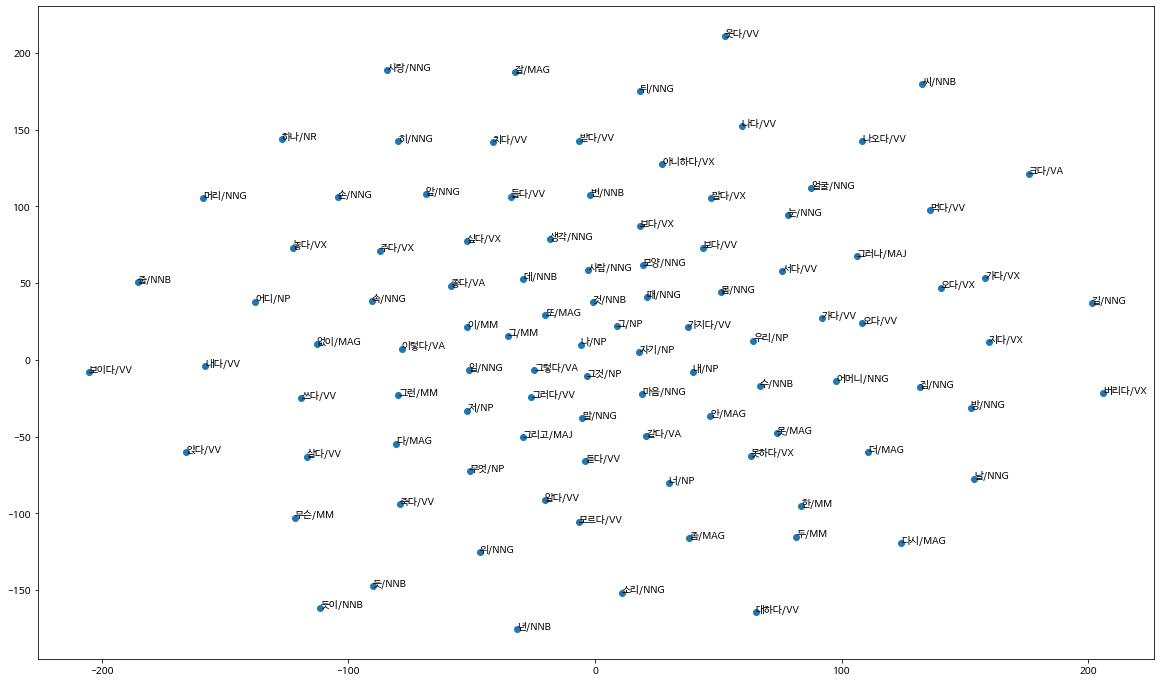

In [101]:
fig = plt.figure()
fig.set_size_inches(20, 12)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(w2v_100['x'], w2v_100['y'])

for word, pos in w2v_100.iterrows():
    ax.annotate(word, pos)
plt.show()

### E1 (~1919)

In [102]:
e1_v200_w3_min30_sg = Word2Vec(sentences=df_sent.loc[df_sent['period'].isin(['E1']),'token'].to_list(), vector_size=200, window=3, min_count=30,sg=1,seed=2021)
e1_v200_w3_min30_sg.save('e1_v200_w3_min30_sg.model') # 모델 저장. 모델 로드할때는 model= Word2Vec.load('v200_w3_min300_sg.model')

In [103]:
# 해당 단어와 문맥이 비슷한 유사어 추출
e1_v200_w3_min30_sg.wv.most_similar('우리/NP', topn=20)  # get other similar words

[('양반/NNG', 0.7432804107666016),
 ('대감/NNG', 0.7307907342910767),
 ('상감/NNG', 0.7259873747825623),
 ('마마/NNG', 0.7163422107696533),
 ('아기/NNG', 0.7159674763679504),
 ('마님/NNG', 0.7153601050376892),
 ('소인/NP', 0.7146469950675964),
 ('에그/IC', 0.7140340209007263),
 ('원수/NNG', 0.709338366985321),
 ('나으리/NNG', 0.7082664370536804),
 ('옥중/NNG', 0.7026922702789307),
 ('뉘/NP', 0.7008689045906067),
 ('계시다/VV', 0.6967805027961731),
 ('난리/NNG', 0.6967130303382874),
 ('산소/NNG', 0.6892068982124329),
 ('가난/NNG', 0.6877405643463135),
 ('오죽/MAG', 0.6868680119514465),
 ('갚다/VV', 0.6847838163375854),
 ('저것/NP', 0.6839969754219055),
 ('하느님/NNG', 0.6836492419242859)]

In [104]:
e1_v200_w3_min30_sg.wv.most_similar('저희/NP', topn=20)  # get other similar words

[('낙/NNG', 0.9467981457710266),
 ('핑계/NNG', 0.944441556930542),
 ('틀리다/VV', 0.9424197673797607),
 ('읍/NNG', 0.9383911490440369),
 ('변변/XR', 0.9372061491012573),
 ('살림/NNG', 0.9371118545532227),
 ('거절/NNG', 0.9370797276496887),
 ('제일/NNG', 0.9342509508132935),
 ('버릇/NNG', 0.9337849020957947),
 ('애쓰다/VV', 0.9336997866630554),
 ('노형/NNG', 0.9307810068130493),
 ('그러니까/MAJ', 0.9304453134536743),
 ('아니오/IC', 0.9281466007232666),
 ('증거/NNG', 0.9280188679695129),
 ('인제/NNG', 0.9276013970375061),
 ('희롱/NNG', 0.9244490265846252),
 ('결과/NNG', 0.9237037897109985),
 ('시험/NNG', 0.9223479628562927),
 ('대접/NNG', 0.9217917919158936),
 ('신분/NNG', 0.9207299947738647)]

In [105]:
e1_v200_w3_min30_sg.wv.most_similar('내/NP', topn=20)  # get other similar words

[('그래/IC', 0.8402311205863953),
 ('네/NP', 0.8316232562065125),
 ('제/NP', 0.8278038501739502),
 ('너희/NP', 0.8227038383483887),
 ('잘못/NNG', 0.816862940788269),
 ('그만두다/VV', 0.8118675351142883),
 ('네/IC', 0.8066691160202026),
 ('어떻게/MAG', 0.8049448132514954),
 ('인제/MAG', 0.8039368391036987),
 ('글쎄/IC', 0.8019675016403198),
 ('에그/IC', 0.8000947833061218),
 ('옳지/IC', 0.7957115769386292),
 ('그까짓/MM', 0.7956680655479431),
 ('설마/MAG', 0.7952634692192078),
 ('계시다/VX', 0.7936150431632996),
 ('오죽/MAG', 0.7933211922645569),
 ('계집애/NNG', 0.7924179434776306),
 ('저것/NP', 0.7921146154403687),
 ('저런/MM', 0.7916524410247803),
 ('진작/MAG', 0.7889196872711182)]

In [106]:
# 해당 단어(2개 이상)와 문맥이 비슷한 유사어 추출
e1_v200_w3_min30_sg.wv.most_similar(['우리/NP','저희/NP'], topn=20)  # get other similar words

[('가난/NNG', 0.8984491229057312),
 ('나으리/NNG', 0.8967321515083313),
 ('소인/NP', 0.8867154717445374),
 ('아기/NNG', 0.8833942413330078),
 ('사돈/NNG', 0.8808977007865906),
 ('오죽/MAG', 0.8796101212501526),
 ('맡기다/VV', 0.8753249645233154),
 ('탓/NNG', 0.8748322129249573),
 ('인제/NNG', 0.8747323155403137),
 ('설마/MAG', 0.8746882677078247),
 ('일가/NNG', 0.873896598815918),
 ('애쓰다/VV', 0.8733710050582886),
 ('인연/NNG', 0.8726142644882202),
 ('저것/NP', 0.8720356225967407),
 ('핑계/NNG', 0.8720336556434631),
 ('그러니까/MAJ', 0.8719590902328491),
 ('버릇/NNG', 0.8710283041000366),
 ('자라나다/VV', 0.8701019883155823),
 ('계시다/VX', 0.8692147135734558),
 ('난리/NNG', 0.8691930770874023)]

In [107]:
# 단어끼리 계산 해보기 
# 우리 + 나 - 너 ?
e1_v200_w3_min30_sg.wv.most_similar(positive=['우리/NP','나/NP'],negative=['너/NP'],topn=20) 

[('하느님/NNG', 0.6803587079048157),
 ('돌아가다/VV', 0.663502037525177),
 ('대감/NNG', 0.6558127403259277),
 ('상감/NNG', 0.6467888355255127),
 ('감사/NNG', 0.6435618996620178),
 ('가난/NNG', 0.6392996907234192),
 ('조상/NNG', 0.6344209909439087),
 ('더구나/MAG', 0.6332551836967468),
 ('옥중/NNG', 0.629854679107666),
 ('아기/NNG', 0.619725227355957),
 ('양반/NNG', 0.6153671741485596),
 ('계림/NNP', 0.6126893758773804),
 ('늘/MAG', 0.6120322346687317),
 ('사촌/NNG', 0.6091736555099487),
 ('둘째/NR', 0.6088511943817139),
 ('명령/NNG', 0.6065929532051086),
 ('난리/NNG', 0.6054033637046814),
 ('그대/NP', 0.6043760180473328),
 ('정하다/VV', 0.6027987003326416),
 ('마마/NNG', 0.602450966835022)]

In [108]:
# 입력한 단어 중 가장 관련성이 적은 것을 뺀다면?
e1_v200_w3_min30_sg.wv.doesnt_match(['나/NP','너/NP','우리/NP','저희/NP'])

'우리/NP'

In [114]:
vocab =list(e1_v200_w3_min30_sg.wv.key_to_index)
X = e1_v200_w3_min30_sg.wv[vocab] 

In [115]:

e1_v200_w3_min30_sg.wv[vocab].shape

(2132, 200)

In [116]:
tsne = TSNE(n_components=2) # 2차원으로 축소

In [117]:
X_tsne = tsne.fit_transform(X[:100,:])
X_tsne

array([[-7.17200518e+00, -6.16274643e+01],
       [-7.31880045e+00, -6.73287821e+00],
       [ 3.70047340e+01, -6.44302034e+00],
       [ 3.82872620e+01,  9.29209042e+00],
       [ 6.92473590e-01, -6.09675865e+01],
       [-5.11262894e-01,  8.72249031e+00],
       [ 6.06278038e+01,  1.15942554e+01],
       [ 4.15344810e+00, -2.10119972e+01],
       [-6.14320488e+01, -1.86301384e+01],
       [ 2.71536694e+01, -3.13177919e+00],
       [ 5.38608589e+01,  6.60709667e+00],
       [ 7.97722197e+00, -7.81700439e+01],
       [-1.13050537e+01, -4.09999542e+01],
       [ 1.86458664e+01, -2.92949371e+01],
       [-6.70542679e+01,  1.63610210e+01],
       [-2.02067947e+01, -3.27739754e+01],
       [-1.04046307e+01,  5.42158470e+01],
       [ 2.50030975e+01,  6.33812790e+01],
       [-7.58877134e+00,  1.56654587e+01],
       [ 3.57001138e+00,  2.69214668e+01],
       [-2.23255777e+00, -3.54375076e+01],
       [-5.75932312e+01, -5.18028450e+01],
       [-7.43304749e+01,  4.15739746e+01],
       [ 1.

In [118]:
# 차원축소 결과 확인
w2v_100 = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
w2v_100

,x,y
그/MM,-7.172005,-61.627464
것/NNB,-7.318800,-6.732878
말/NNG,37.004734,-6.443020
보다/VV,38.287262,9.292090
이/MM,0.692474,-60.967587
...,...,...
놈/NNB,-1.842495,73.499931
웃다/VV,-4.623836,42.181293
듯이/NNB,-26.327351,24.707525
왜/MAG,26.582747,-14.467678


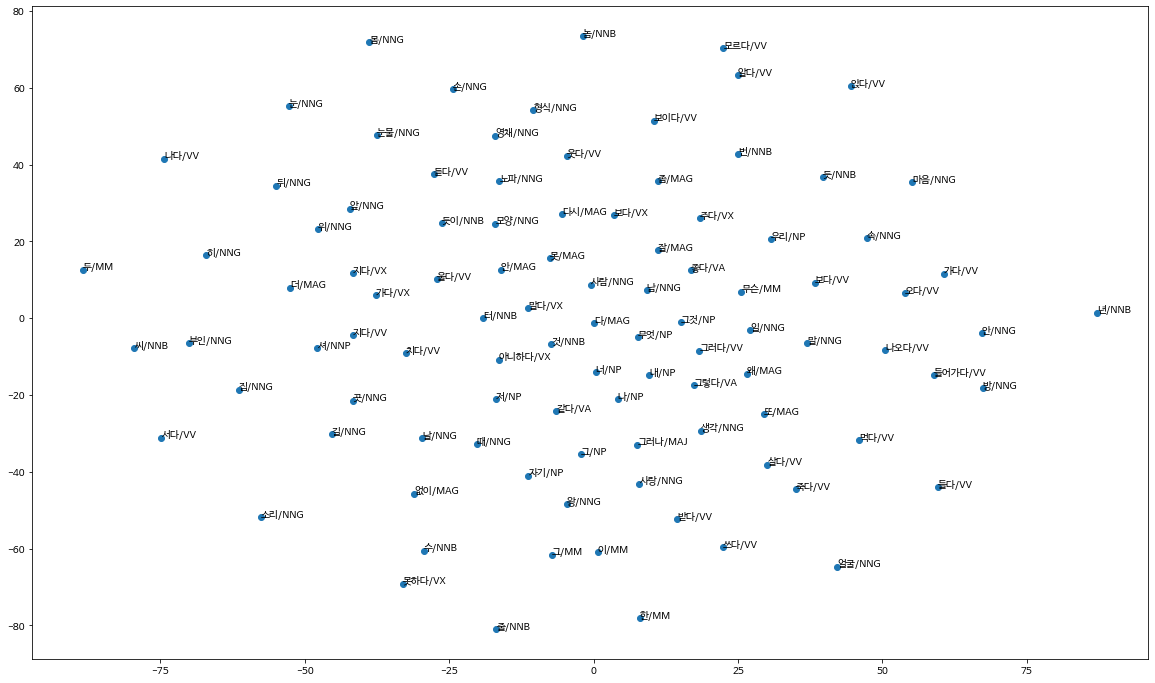

In [119]:
fig = plt.figure()
fig.set_size_inches(20, 12)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(w2v_100['x'], w2v_100['y'])

for word, pos in w2v_100.iterrows():
    ax.annotate(word, pos)
plt.show()

### E2 (1919~1945)

In [120]:
e2_v200_w3_min30_sg = Word2Vec(sentences=df_sent.loc[df_sent['period'].isin(['E2']),'token'].to_list(), vector_size=200, window=3, min_count=30,sg=1,seed=2021)
e2_v200_w3_min30_sg.save('e2_v200_w3_min30_sg.model') # 모델 저장. 모델 로드할때는 model= Word2Vec.load('v200_w3_min300_sg.model')

In [121]:
# 해당 단어와 문맥이 비슷한 유사어 추출
e2_v200_w3_min30_sg.wv.most_similar('우리/NP', topn=20)  # get other similar words

[('저희/NP', 0.5567991733551025),
 ('자아/NNG', 0.4941699206829071),
 ('여러분/NP', 0.47655609250068665),
 ('구장/NNG', 0.47186610102653503),
 ('어긋나다/VV', 0.46387431025505066),
 ('너희/NP', 0.46254491806030273),
 ('나/NP', 0.4606829583644867),
 ('아뇨/IC', 0.46056270599365234),
 ('느이/NP', 0.4588398337364197),
 ('어차피/MAG', 0.457431823015213),
 ('소승/NNG', 0.45739537477493286),
 ('그렇잖다/VA', 0.4539205729961395),
 ('자아/IC', 0.44604936242103577),
 ('저이/NP', 0.4457774758338928),
 ('그분/NP', 0.44563087821006775),
 ('그리구/MAJ', 0.44545093178749084),
 ('더군다/NNG', 0.4438675045967102),
 ('내/NP', 0.44308754801750183),
 ('할아버지/NNG', 0.44024115800857544),
 ('에그/IC', 0.4383631944656372)]

In [122]:
e2_v200_w3_min30_sg.wv.most_similar('저희/NP', topn=20)  # get other similar words

[('그렇지/IC', 0.6418583989143372),
 ('저이/NP', 0.6398590207099915),
 ('엇/IC', 0.6355642080307007),
 ('아니요/IC', 0.6332716345787048),
 ('ᆸ디까/NNP', 0.6327929496765137),
 ('그렇잖다/VA', 0.6245807409286499),
 ('아니오/IC', 0.623073399066925),
 ('거저/MAG', 0.6224877238273621),
 ('느이/NP', 0.6196048855781555),
 ('아뇨/IC', 0.6192252039909363),
 ('그러구/MAJ', 0.6184384822845459),
 ('새언니/NNG', 0.6126431226730347),
 ('웬걸/IC', 0.6122901439666748),
 ('보모/NNG', 0.6121532917022705),
 ('딸자식/NNG', 0.6101364493370056),
 ('너희/NP', 0.6100708246231079),
 ('그자/NP', 0.6098355054855347),
 ('못난이/NNG', 0.6093986630439758),
 ('그러니/MAJ', 0.6086239218711853),
 ('덕분/NNG', 0.6085164546966553)]

In [123]:
e2_v200_w3_min30_sg.wv.most_similar('내/NP', topn=20)  # get other similar words

[('나/NP', 0.6568447947502136),
 ('고발/NNG', 0.6510831117630005),
 ('아부지/NNG', 0.6466047763824463),
 ('네/NP', 0.6373305320739746),
 ('아니야/IC', 0.6317177414894104),
 ('얘/NP', 0.6248271465301514),
 ('여보세요/IC', 0.6241090893745422),
 ('제/NP', 0.6114066243171692),
 ('어떡/XR', 0.604287326335907),
 ('진작/MAG', 0.6040663719177246),
 ('그러게/IC', 0.6022891998291016),
 ('하긴/MAJ', 0.6019155979156494),
 ('어차피/MAG', 0.6009189486503601),
 ('정말/NNG', 0.5994312763214111),
 ('노형/NNG', 0.5960201025009155),
 ('이애/IC', 0.5955280065536499),
 ('헤/IC', 0.5951776504516602),
 ('그러니깐/MAJ', 0.5895903706550598),
 ('요것/NP', 0.5850978493690491),
 ('ᆸ디까/NNP', 0.5844789743423462)]

In [124]:
# 해당 단어(2개 이상)와 문맥이 비슷한 유사어 추출
e2_v200_w3_min30_sg.wv.most_similar(['우리/NP','저희/NP'], topn=20)  # get other similar words

[('저이/NP', 0.6152521967887878),
 ('아뇨/IC', 0.6119375824928284),
 ('그렇잖다/VA', 0.611208438873291),
 ('느이/NP', 0.6111763715744019),
 ('자아/NNG', 0.6082602143287659),
 ('너희/NP', 0.6078730225563049),
 ('그렇지/IC', 0.6077497005462646),
 ('ᆸ디까/NNP', 0.6044958233833313),
 ('엇/IC', 0.6010869741439819),
 ('어차피/MAG', 0.5979206562042236),
 ('아니요/IC', 0.5949589610099792),
 ('웬걸/IC', 0.5927339196205139),
 ('용례/NNG', 0.5910272002220154),
 ('할아버지/NNG', 0.5887600183486938),
 ('에그/IC', 0.587836742401123),
 ('덕분/NNG', 0.5870852470397949),
 ('구장/NNG', 0.58678138256073),
 ('그러구/MAJ', 0.5864646434783936),
 ('소승/NNG', 0.5835950374603271),
 ('거저/MAG', 0.5813125967979431)]

In [125]:
# 단어끼리 계산 해보기 
# 우리 + 나 - 너 ?
e2_v200_w3_min30_sg.wv.most_similar(positive=['우리/NP','나/NP'],negative=['너/NP'],topn=20) 

[('여러분/NP', 0.4508058726787567),
 ('내/NP', 0.4355165362358093),
 ('저희/NP', 0.432745099067688),
 ('어긋나다/VV', 0.41105881333351135),
 ('자아/NNG', 0.40875765681266785),
 ('어차피/MAG', 0.38931724429130554),
 ('분상/NNG', 0.37925854325294495),
 ('조선/NNP', 0.3772542178630829),
 ('여보세요/IC', 0.3763405978679657),
 ('유봉/NNP', 0.3709563910961151),
 ('아뇨/IC', 0.36693984270095825),
 ('그렇잖다/VA', 0.364808589220047),
 ('왔다/NNG', 0.3634376525878906),
 ('금봉이/NNP', 0.3617132306098938),
 ('당분간/MAG', 0.3616066873073578),
 ('더군다/NNG', 0.3597927689552307),
 ('그네/NP', 0.35868531465530396),
 ('불행/NNG', 0.35650742053985596),
 ('동포/NNG', 0.35618168115615845),
 ('조물주/NNG', 0.3537052869796753)]

In [126]:
# 입력한 단어 중 가장 관련성이 적은 것을 뺀다면?
e2_v200_w3_min30_sg.wv.doesnt_match(['나/NP','너/NP','우리/NP','저희/NP'])

'너/NP'

In [127]:
vocab =list(e2_v200_w3_min30_sg.wv.key_to_index)
X = e2_v200_w3_min30_sg.wv[vocab] 

In [128]:
e2_v200_w3_min30_sg.wv[vocab].shape

(8201, 200)

In [129]:
tsne = TSNE(n_components=2) # 2차원으로 축소

In [144]:
X_tsne = tsne.fit_transform(X[:100,:])
X_tsne

array([[  35.274918  ,   -5.288719  ],
       [  -4.382321  ,    2.7728658 ],
       [ -24.45734   ,   16.59254   ],
       [  16.161238  ,  -10.275758  ],
       [  14.2400055 ,    8.242616  ],
       [  -6.3758783 ,  -13.559693  ],
       [  30.15076   ,   14.896765  ],
       [  19.23673   ,   35.85017   ],
       [ -27.81652   ,   -5.792771  ],
       [  48.404823  ,   34.922     ],
       [ -14.250674  ,   44.699306  ],
       [  50.75076   ,    8.775734  ],
       [  41.569214  ,   49.32608   ],
       [  16.4286    ,  -54.497444  ],
       [  71.37237   ,   -0.9867515 ],
       [ -90.50879   ,   -8.562478  ],
       [  40.707535  ,  -67.32855   ],
       [ -17.270594  ,  -33.459133  ],
       [  96.01796   ,   -3.603005  ],
       [  84.116615  , -122.17521   ],
       [  31.60691   ,   73.58458   ],
       [ -94.20529   ,   39.064953  ],
       [ -40.2535    ,  -75.950134  ],
       [  34.747913  ,  183.18806   ],
       [-173.89032   ,   25.765959  ],
       [ -40.725548  ,  -

In [145]:
# 차원축소 결과 확인
w2v_100 = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
w2v_100

,x,y
것/NNB,35.274918,-5.288719
그/MM,-4.382321,2.772866
말/NNG,-24.457340,16.592541
나/NP,16.161238,-10.275758
그/NP,14.240005,8.242616
...,...,...
가지다/VV,88.435394,-169.493744
잘/MAG,129.558716,-130.497101
사랑/NNG,40.432186,-41.864407
웃다/VV,-50.452232,-108.087059


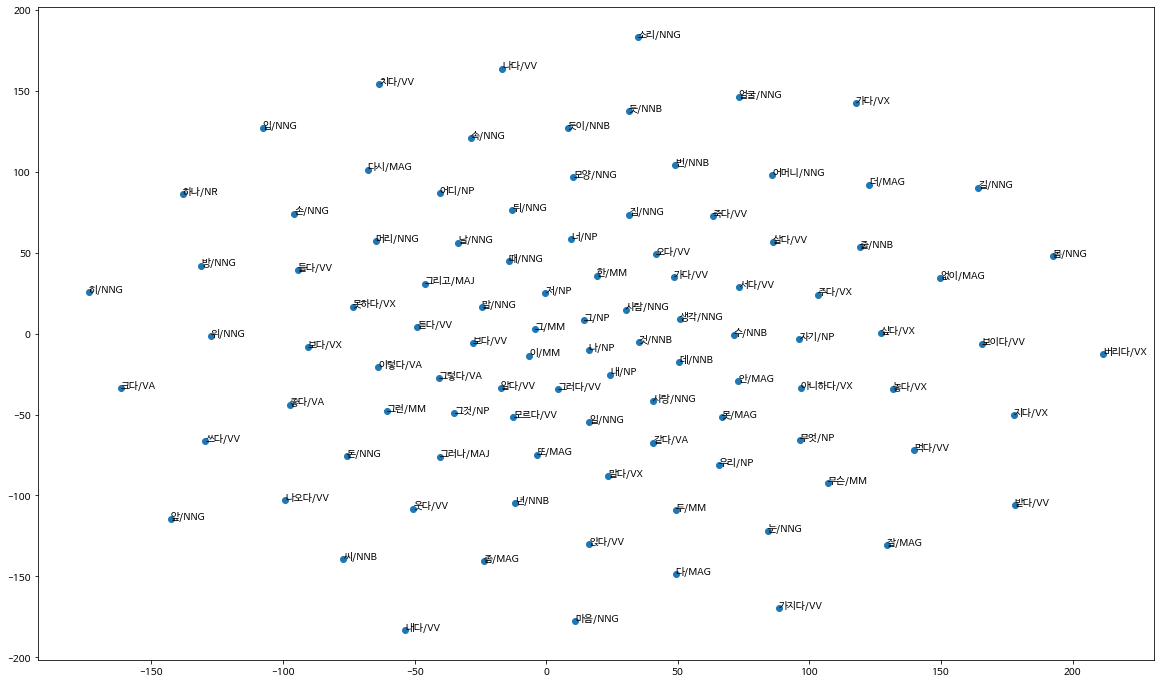

In [146]:
fig = plt.figure()
fig.set_size_inches(20, 12)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(w2v_100['x'], w2v_100['y'])

for word, pos in w2v_100.iterrows():
    ax.annotate(word, pos)
plt.show()

### E3 (1945 ~)

In [141]:
e3_v200_w3_min30_sg = Word2Vec(sentences=df_sent.loc[df_sent['period'].isin(['E3']),'token'].to_list(), vector_size=200, window=3, min_count=30,sg=1,seed=2021)
e3_v200_w3_min30_sg.save('e3_v200_w3_min30_sg.model') # 모델 저장. 모델 로드할때는 model= Word2Vec.load('v200_w3_min300_sg.model')

In [147]:
# 해당 단어와 문맥이 비슷한 유사어 추출
e3_v200_w3_min30_sg.wv.most_similar('우리/NP', topn=20)  # get other similar words

[('조상/NNG', 0.6897330284118652),
 ('망하다/VV', 0.6774724721908569),
 ('흥사단/NNP', 0.6663060188293457),
 ('독립/NNG', 0.6631767749786377),
 ('대한/NNP', 0.6539252996444702),
 ('동방/NNG', 0.6384645700454712),
 ('둘째/NR', 0.6382561326026917),
 ('조선/NNP', 0.6377639770507812),
 ('첫째/NR', 0.637111246585846),
 ('배달/NNG', 0.6351361274719238),
 ('천만/NR', 0.6339439153671265),
 ('민족/NNG', 0.6322430372238159),
 ('적/NNG', 0.631158709526062),
 ('한국인/NNG', 0.6297333836555481),
 ('영국/NNP', 0.6295753717422485),
 ('반드시/MAG', 0.6270061731338501),
 ('한인/NNG', 0.6266093254089355),
 ('싸우다/VV', 0.6259425282478333),
 ('국토/NNG', 0.6228644847869873),
 ('장래/NNG', 0.6221791505813599)]

In [148]:
e3_v200_w3_min30_sg.wv.most_similar('저희/NP', topn=20)  # get other similar words

[('이웃/NNG', 0.8778594136238098),
 ('참석/NNG', 0.860874593257904),
 ('수고/NNG', 0.8582231402397156),
 ('도대체/MAG', 0.8547378182411194),
 ('자살/NNG', 0.8546241521835327),
 ('상감/NNG', 0.8466712236404419),
 ('제일/NNG', 0.8461747765541077),
 ('물러가다/VV', 0.8432782888412476),
 ('동무/NNG', 0.8418965339660645),
 ('아버님/NNG', 0.8413043022155762),
 ('승/NNG', 0.8412179946899414),
 ('아무/NP', 0.840582549571991),
 ('빼앗기다/VV', 0.8394209146499634),
 ('김창수/NNP', 0.8385441303253174),
 ('태어나다/VV', 0.838119387626648),
 ('겸/NNB', 0.8353295922279358),
 ('바둑/NNG', 0.8330913782119751),
 ('약속/NNG', 0.832243025302887),
 ('지원/NNG', 0.8317490816116333),
 ('마련/NNG', 0.8316033482551575)]

In [149]:
e3_v200_w3_min30_sg.wv.most_similar('내/NP', topn=20)  # get other similar words

[('네/NP', 0.8092668056488037),
 ('김창수/NNP', 0.8001568913459778),
 ('게/NNG', 0.7966243624687195),
 ('아저씨/NNG', 0.7906723618507385),
 ('오냐/IC', 0.7845122814178467),
 ('백군/NNG', 0.7823688983917236),
 ('어떻게/MAG', 0.781096339225769),
 ('도대체/MAG', 0.7808334231376648),
 ('소인/NNG', 0.777097225189209),
 ('아무/NP', 0.7755645513534546),
 ('자살/NNG', 0.771573543548584),
 ('글쎄/MAG', 0.7696906328201294),
 ('소인/NP', 0.7694709300994873),
 ('상감/NNG', 0.7674873471260071),
 ('당신/NP', 0.7657020688056946),
 ('이놈/NP', 0.7643461227416992),
 ('료/NNG', 0.7639786601066589),
 ('살림/NNG', 0.7639562487602234),
 ('누이/NNG', 0.7607905864715576),
 ('뭣/NP', 0.7601182460784912)]

In [150]:
# 해당 단어(2개 이상)와 문맥이 비슷한 유사어 추출
e3_v200_w3_min30_sg.wv.most_similar(['우리/NP','저희/NP'], topn=20)  # get other similar words

[('이웃/NNG', 0.8246166706085205),
 ('지원/NNG', 0.8012602925300598),
 ('빼앗기다/VV', 0.7975645661354065),
 ('영광/NNG', 0.7953705787658691),
 ('장차/MAG', 0.7937458157539368),
 ('겸/NNB', 0.7910500764846802),
 ('승/NNG', 0.7888133525848389),
 ('망하다/VV', 0.7886082530021667),
 ('한국인/NNG', 0.787964940071106),
 ('첫째/NR', 0.7863497138023376),
 ('반드시/MAG', 0.7837596535682678),
 ('도대체/MAG', 0.783482551574707),
 ('혼인/NNG', 0.7833316922187805),
 ('자살/NNG', 0.7826310992240906),
 ('상감/NNG', 0.7819489240646362),
 ('영국/NNP', 0.7802878022193909),
 ('왜놈/NNG', 0.7799764275550842),
 ('마련/NNG', 0.7762740850448608),
 ('제일/NNG', 0.7762603163719177),
 ('적/NNG', 0.7744870185852051)]

In [151]:
# 단어끼리 계산 해보기 
# 우리 + 나 - 너 ?
e3_v200_w3_min30_sg.wv.most_similar(positive=['우리/NP','나/NP'],negative=['너/NP'],topn=20) 

[('완성/NNG', 0.5724137425422668),
 ('인류/NNG', 0.5633914470672607),
 ('장래/NNG', 0.5580561757087708),
 ('굳다/VA', 0.5551350116729736),
 ('반드시/MAG', 0.5526914000511169),
 ('참되다/VA', 0.5507771968841553),
 ('마찬가지/NNG', 0.5489625930786133),
 ('전체/NNG', 0.5448722839355469),
 ('국토/NNG', 0.5440258383750916),
 ('유일/NNG', 0.5426980257034302),
 ('기초/NNG', 0.5423750877380371),
 ('현재/NNG', 0.5419335961341858),
 ('가져오다/VV', 0.5412359237670898),
 ('영원/NNG', 0.5382866263389587),
 ('강요/NNG', 0.5381848216056824),
 ('여러분/NP', 0.5372580289840698),
 ('파괴/NNG', 0.5339288115501404),
 ('정당/NNG', 0.5324827432632446),
 ('지성/NNG', 0.5320195555686951),
 ('개인/NNG', 0.5307300090789795)]

In [152]:
# 입력한 단어 중 가장 관련성이 적은 것을 뺀다면?
e3_v200_w3_min30_sg.wv.doesnt_match(['나/NP','너/NP','우리/NP','저희/NP'])

'우리/NP'

##### Word2vec 차원축소 시각화

In [154]:
vocab =list(e3_v200_w3_min30_sg.wv.key_to_index)
X = e3_v200_w3_min30_sg.wv[vocab] 

In [156]:
# X?
e3_v200_w3_min30_sg.wv[vocab].shape

(2637, 200)

In [157]:
tsne = TSNE(n_components=2) # 2차원으로 축소

In [158]:
X_tsne = tsne.fit_transform(X[:100,:])
X_tsne

array([[  31.248373 ,    6.3085465],
       [ -39.873203 ,  104.21849  ],
       [   4.967211 ,  -54.62573  ],
       [-124.2745   , -209.84282  ],
       [ 118.35371  ,  -16.571447 ],
       [ -71.28262  ,  101.805786 ],
       [  -2.379894 ,   -0.8151694],
       [ -10.284964 ,   34.923058 ],
       [ 244.58691  ,   -1.5984893],
       [ -15.613351 ,  149.09184  ],
       [-208.788    ,  -26.934286 ],
       [  25.781586 ,  104.36573  ],
       [  83.014114 ,  -19.535095 ],
       [-104.47346  ,   30.040728 ],
       [ 221.40163  ,  -18.92195  ],
       [  18.590485 ,  -22.741667 ],
       [ -63.768578 ,   53.181755 ],
       [  -2.2516563, -255.22583  ],
       [ 151.96735  ,  -98.2395   ],
       [ -10.581684 ,   74.14915  ],
       [-177.54333  ,  -50.019424 ],
       [ 173.48972  ,   -8.971019 ],
       [-112.26035  ,  -49.490376 ],
       [ 102.31974  ,  -54.181618 ],
       [ -16.914553 , -109.48212  ],
       [ 310.60266  ,   18.55117  ],
       [  83.94741  ,   67.72734  ],
 

In [159]:
# 차원축소 결과 확인
w2v_100 = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
w2v_100

,x,y
것/NNB,31.248373,6.308547
그/MM,-39.873203,104.218491
나/NP,4.967211,-54.625729
한/MM,-124.274498,-209.842819
말/NNG,118.353706,-16.571447
...,...,...
나다/VV,113.984695,98.894997
가다/VX,175.313202,161.708969
뒤/NNG,186.794708,-90.099174
보이다/VV,15.793386,153.544113


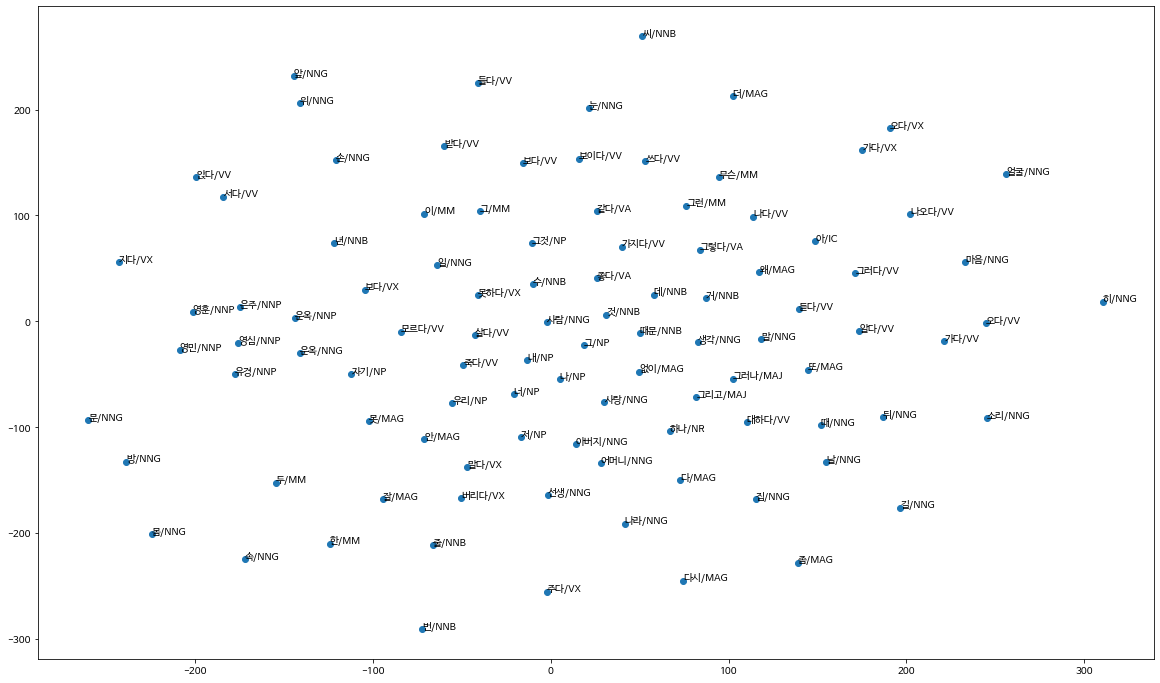

In [160]:
fig = plt.figure()
fig.set_size_inches(20, 12)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(w2v_100['x'], w2v_100['y'])

for word, pos in w2v_100.iterrows():
    ax.annotate(word, pos)
plt.show()